# Towards solid solutions

- [Build and the energy model](#energy_model)
- [Chemical potential](#chemical_potential)
- [Run the anneal](#anneal)
- [New workflow](#workflow)
- [Diamond](#diamond)
- [DQM](#dqm)

In [1]:
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

from dwave.embedding.chain_strength import  uniform_torque_compensation

import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from pymatgen.ext.matproj import MPRester

from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import sys
sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
from crystal_io import *
from convert import *
import re
import shutil as sh

#from CRYSTALpytools.crystal_io import * 
#from CRYSTALpytools.convert import * 
#from crystal_functions.execute import *

import copy
from sklearn.metrics import mean_squared_error 

import dataframe_image as dfi

In [2]:
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

In [3]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  7.80]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

18

In [134]:
cry_pmg2gui(graphene,dimensionality=3).write_crystal_gui('./data/crystal/graphite_prim.gui')

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

'''lattice = np.array([[0.000000000000E+00,   0.178500000000E+01,   0.178500000000E+01],
                   [ 0.178500000000E+01,   0.000000000000E+00,   0.178500000000E+01],
                   [ 0.178500000000E+01,   0.178500000000E+01,   0.000000000000E+00]])'''

lattice = np.zeros((3,3))
lattice
np.fill_diagonal(lattice,3.57247967)



diamond = Structure(lattice, species=['C','C'], coords=[[1/8, 1/8, 1/8 ],[-1/8, -1/8, -1/8]])
diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()

diamond_gui = Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond.gui')
diamond = cry_gui2pmg(diamond_gui)

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
diamond_supercell = copy.deepcopy(diamond)
diamond_supercell.make_supercell(scaling_matrix)
structure = diamond_supercell
diamond_supercell.num_sites

54

In [197]:
view(AseAtomsAdaptor().get_atoms(diamond_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [199]:
np.unique(np.round(diamond_supercell.distance_matrix[0],5),return_counts=True)

(array([0.     , 1.54693, 2.52612, 2.96214, 3.57248, 3.89302, 4.37538,
        4.64079]),
 array([ 1,  4, 12, 12,  6,  6,  8,  5]))

In [139]:
cry_gui2pmg(Crystal_gui().read_cry_gui('./data/crystal/graphite_prim.gui'))

Structure Summary
Lattice
    abc : 2.4739598665976326 2.473959897005048 7.80000913875
 angles : 89.99999999870458 89.99999999919783 119.99994033145616
 volume : 41.34388746302567
      A : 1.23698104132 -2.1425114527 1.73133605849e-11
      B : 1.23698107172 2.14251147026 2.79590966408e-11
      C : 1.42820421171e-10 1.93904222684e-11 7.80000913875
PeriodicSite: C (1.2370, 0.7142, -0.0000) [0.3333, 0.6667, -0.0000]
PeriodicSite: C (1.2370, -0.7142, 0.0000) [0.6667, 0.3333, 0.0000]

# <a id='energy_model'>Build discrete QUBO</a>

### Graphene

In [6]:
# Calculating the bond energy

### Method 1: Frozen bonds

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
N_C = structure.num_sites

N_CC = N_C*1.5

### Graphene pure
crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s.out'%N_C)
E_g = crystal_output.get_final_energy()

### C atom

#E_C = Crystal_output().read_cry_output('./data/crystal/c.out').get_final_energy()
E_C = Crystal_output().read_cry_output('./data/crystal/graphite.out').get_final_energy()

E_C/=4
E_C = Crystal_output().read_cry_output('./data/crystal/c.out').get_final_energy()

### N atom

#E_N = Crystal_output().read_cry_output('./data/crystal/n.out').get_final_energy()

E_N = Crystal_output().read_cry_output('./data/crystal/n2.out').get_final_energy()
E_N/=2
E_N = Crystal_output().read_cry_output('./data/crystal/n.out').get_final_energy()

### Graphene 1 N

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_1N.out'%N_C)
E_g1N = crystal_output.get_final_energy()


### Graphene 2 N max dist

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2N.out'%N_C)
E_g2N = crystal_output.get_final_energy()


### Graphene 2 N 2nd shell

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2N2s.out'%N_C)
E_g2N2s = crystal_output.get_final_energy()

### Graphene 3 N 3nd shell

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2N3s.out'%N_C)
E_g2N3s = crystal_output.get_final_energy()


### Graphene 2 N neighbours

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2Nn.out'%N_C)
E_g2Nn = crystal_output.get_final_energy()


### Graphene 3 N 2nd shell

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_3N2s.out'%N_C)
E_g3N2s = crystal_output.get_final_energy()


### Bond energies

E_CC = (E_g - (N_C*E_C))/N_CC
E_CN = (E_g1N-((N_C-1)*E_C + 1*E_N + (N_CC-3)*E_CC))/3
E_CN_b = (E_g2N-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC))/6

E_CN_p = (E_g2N2s-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC +4*E_CN))/2
E_CN_s = (E_g3N2s-((N_C-3)*E_C + 3*E_N + (N_CC-9)*E_CC +6*E_CN))/3

E_NN = (E_g2Nn-((N_C-2)*E_C + 2*E_N + (N_CC-5)*E_CC +4*E_CN))
print('E_CC = ',E_CC)
print('E_CN = ',E_CN)
#print('E_CN_b = ',E_CN_b)
#print('E_CN_p = ',E_CN_p)
#print('E_CN_s = ',E_CN_s)
print('E_NN = ',E_NN)

E_CC =  -6.801539327892694
E_CN =  -6.0070660337235795
E_NN =  -4.187297147986101


### Diamond

In [168]:
# Calculating the bond energy

### Method 1: Frozen bonds

diamond_gui = Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond_54.gui')
diamond_supercell = cry_gui2pmg(diamond_gui)
#diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()

#n_supercell = 2
#scaling_matrix = np.identity(3)*n_supercell
#diamond_supercell = copy.deepcopy(diamond)
#diamond_supercell.make_supercell(scaling_matrix)
#diamond_supercell.num_sites

N_C = diamond_supercell.num_sites

N_CC = N_C*2

### Diamond pure
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s.out'%N_C)
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_prim_pbe.out')
E_d = crystal_output.get_final_energy()

### C atom

#E_C = Crystal_output().read_cry_output('./data/crystal/c.out').get_final_energy()
#E_C = Crystal_output().read_cry_output('./data/crystal/graphite.out').get_final_energy()

#E_C/=4
E_C = Crystal_output().read_cry_output('./data/crystal/diamond/c_pbe.out').get_final_energy()

### N atom

#E_N = Crystal_output().read_cry_output('./data/crystal/n.out').get_final_energy()

#E_N = Crystal_output().read_cry_output('./data/crystal/n2.out').get_final_energy()
#E_N/=2
E_N = Crystal_output().read_cry_output('./data/crystal/diamond/n.out').get_final_energy()

### Diamond 1 N

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_1N.out'%N_C)
E_d1N = crystal_output.get_final_energy()


### Diamond 2 N max dist

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N.out'%N_C)
E_d2N = crystal_output.get_final_energy()


### Diamond 2 N 2nd shell

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N2s.out'%N_C)
E_d2N2s = crystal_output.get_final_energy()

### Diamond 2 N 3nd shell

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N3s.out'%N_C)
E_d2N3s = crystal_output.get_final_energy()


### Diamond 2 N neighbours

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2Nn.out'%N_C)
E_d2Nn = crystal_output.get_final_energy()


### Diamond 3 N 2nd shell

#crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_3N2s.out'%N_C)
#E_d3N2s = crystal_output.get_final_energy()


### Bond energies

E_CC = (E_d - (N_C*E_C))/N_CC
E_CN = (E_d1N-((N_C-1)*E_C + 1*E_N + (N_CC-3)*E_CC))/3
E_CN_b = (E_d2N-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC))/6

E_CN_p = (E_d2N2s-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC +4*E_CN))/2
#E_CN_s = (E_d3N2s-((N_C-3)*E_C + 3*E_N + (N_CC-9)*E_CC +6*E_CN))/3

E_NN = (E_d2Nn-((N_C-2)*E_C + 2*E_N + (N_CC-5)*E_CC +4*E_CN))
E_NN_2 = E_d2N2s - E_d2N
E_NN_3 = E_d2N3s - E_d2N
print('E_CC = ',E_CC)
print('E_CN = ',E_CN)
#print('E_CN_b = ',E_CN_b)
#print('E_CN_p = ',E_CN_p)
#print('E_CN_s = ',E_CN_s)
print('E_NN = ',E_NN)
print('E_NN_2 = ',E_NN_2)
print('E_NN_3 = ',E_NN_3)

E_CC =  493.29686835061113
E_CN =  -17456.77533838602
E_NN =  18448.49951444239
E_NN_2 =  0.057219017267925665
E_NN_3 =  0.05717953354178462


In [163]:
E_d

-2070.676618093398

In [169]:
((E_C*2)-E_d)/4

5.129208076370219

In [160]:
((E_C*54)-E_d)/(54*4)

2.8407924377529357

In [169]:
crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N3s.out'%N_C)
crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond_%s_2N3s.gui'%N_C)
np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)
cry_gui2pmg(crystal_gui).distance_matrix[0][54]

2.526124939606197

## Test build interaction

In [39]:
species=[6,7]
parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]

q = build_interaction_matrix_test(structure, species, parameters = parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = 2)
#np.round(q,5)

### 0 N

In [40]:
structure = copy.deepcopy(graphene_supercell)
atomic_numbers = list(structure.atomic_numbers)

x = build_discrete_vector(atomic_numbers,num_species=2)

np.round(E_g-classical_energy(x,q),6)

-0.0

### 1 N

In [42]:
structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
atomic_numbers = list(structure.atomic_numbers)

x = build_discrete_vector(atomic_numbers,num_species=2)

E_g1N-classical_energy(x,q)

-3.637978807091713e-12

### 2 neighbouring N

In [43]:
structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
structure.replace(9,7)
atomic_numbers = list(structure.atomic_numbers)

x = build_discrete_vector(atomic_numbers,num_species=2)

E_g2Nn-classical_energy(x,q)

3.637978807091713e-12

### 2 non-neighbouring N 

#### 2 shell

In [44]:
structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
structure.replace(1,7)
atomic_numbers = list(structure.atomic_numbers)

x = build_discrete_vector(atomic_numbers,num_species=2)

E_g2N2s-classical_energy(x,q)

0.15650695330259623

#### 3 shell

In [45]:
structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
structure.replace(1,7)
atomic_numbers = list(structure.atomic_numbers)

x = build_discrete_vector(atomic_numbers,num_species=2)

E_g2N-classical_energy(x,q)

-0.011765577291953377

In [534]:
x

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

## Test all configurations 3x3

#### 2N

In [40]:
import itertools
X = np.array(list(itertools.product([0, 1], repeat=18)))
two_N = np.where(np.sum(X,axis=1)==16)[0]
X_2 = X[two_N]

In [41]:
all_structures = []
for config in X_2:
    structure = copy.deepcopy(graphene_supercell)
    for j in np.where(config==0)[0]:
        structure.replace(j,7)
    all_structures.append(structure)    


#### Test CME

In [59]:
cme = []
for structure in all_structures:
    cm = 1/structure.distance_matrix
    for i in range(structure.num_sites):
        for j in range(structure.num_sites):
            if i == j:
                cm[i,j] = 0.5*structure.atomic_numbers[i]**2.4
            else:
                cm[i,j] *= structure.atomic_numbers[i]*structure.atomic_numbers[j]
    cme.append(np.round(np.real(np.sort(np.linalg.eig(cm)[0])[::-1]),6))

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_19988/1453460657.py:3: RuntimeWarning: divide by zero encountered in true_divide
  cm = 1/structure.distance_matrix


In [62]:
np.unique(cme,axis=1,return_counts=True)

(array([[ -0.927375,   3.4507  ,   4.398263, ...,  60.861078,  61.472492,
         295.806668],
        [ -0.927375,   3.4507  ,   4.398263, ...,  60.861078,  61.472492,
         295.806668],
        [ -0.927375,   3.4507  ,   4.398263, ...,  60.861078,  61.472492,
         295.806668],
        ...,
        [ -0.927375,   3.4507  ,   4.398263, ...,  60.861078,  61.472492,
         295.806668],
        [ -0.927375,   3.4507  ,   4.398263, ...,  60.861078,  61.472492,
         295.806668],
        [ -0.927375,   3.4507  ,   4.398263, ...,  60.861078,  61.472492,
         295.806668]]),
 array([1, 4, 1, 1, 2, 1, 1, 4, 1, 1, 1]))

In [22]:
from pymatgen.analysis.structure_matcher import StructureMatcher

#Find the unique structures
unique_structures = StructureMatcher().group_structures(all_structures)

unique_structures_label = []

#Find to which class the structures belong to
for structure in all_structures:
    for i in range(len(unique_structures)):
        #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
        if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
            unique_structures_label.append(i)
            break

In [23]:
index_2 = np.unique(unique_structures_label,return_index=True)[1]

In [24]:
unique_config_2N = X_2[index_2]

In [25]:
unique_config_2N

array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]])

In [26]:
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,j in enumerate(index_2):
    crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

    structure = all_structures[j]
    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/2N/graphene_32_2N_%s.gui'%i)
    crystal_input.write_crystal_input('./data/crystal/2N/graphene_32_2N_%s.d12'%i)
    
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_32_2N_%s\n'%i)
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_32_2N_%s\n'%i)
    data.append('\n\n')

    
with open('./data/crystal/2N/graphene_32_2N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)


#### output

In [27]:
cry_energy_2N = []
qubo_energy_2N = []
for i in range(1,4):
    
    n_config = unique_config_2N.shape[0]
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC,E_CN,E_NN]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    q = build_interaction_matrix(structure, [6,7], parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = i)
    #q = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)

    for i in range(n_config):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/2N/graphene_2N_%s.out'%i)
        crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/2N/graphene_2N_%s.gui'%i)
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        x = build_discrete_vector(atomic_numbers,num_species=2)
        qubo_energy.append(classical_energy(x,q))
    cry_energy_2N.append(cry_energy)
    qubo_energy_2N.append(qubo_energy)
cry_energy_2N = np.array(cry_energy_2N)   
qubo_energy_2N = np.array(qubo_energy_2N)

In [29]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_2N[0]



df['QUBO E 1'] = qubo_energy_2N[0]
df['QUBO E 2 '] = qubo_energy_2N[1]
df['QUBO E 3 '] = qubo_energy_2N[2]


df['Delta E 1'] = (qubo_energy_2N[0] - cry_energy_2N[0])
df['Delta E 2 '] = (qubo_energy_2N[1] - cry_energy_2N[0])
df['Delta E 3 '] = (qubo_energy_2N[2] - cry_energy_2N[0])

crystal_E_norm = cry_energy_2N[0] - np.min(cry_energy_2N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_2N[0] - np.min(qubo_energy_2N[0])
qubo2_energy_norm = qubo_energy_2N[1] - np.min(qubo_energy_2N[1])
qubo3_energy_norm = qubo_energy_2N[2] - np.min(qubo_energy_2N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)

std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]

df.loc[len(df.index)] = std

rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_2N[0],qubo_energy_2N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={5: 'STD'},inplace=True)
df.rename(index={6: 'RMSE'},inplace=True)
df = df.round(3)

df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_2N_all_CRY_QUBO.png')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
0,-19534.861,-19535.181,-19535.012,-19535.012,-0.320,-0.152,-0.152,0.495,0.000,0.168,0.176,-0.495,-0.327,-0.319
1,-19535.029,-19535.181,-19535.181,-19535.181,-0.152,-0.152,-0.152,0.327,0.000,0.000,0.008,-0.327,-0.327,-0.319
2,-19534.156,-19534.155,-19534.155,-19534.155,0.000,0.000,0.000,1.200,1.025,1.025,1.033,-0.174,-0.174,-0.167
3,-19535.037,-19535.181,-19535.181,-19535.181,-0.144,-0.144,-0.144,0.319,0.000,0.000,0.008,-0.319,-0.319,-0.311
4,-19535.355,-19535.181,-19535.181,-19535.189,0.175,0.175,0.167,0.000,0.000,0.000,0.000,0.000,0.000,0.000
STD,0.399,0.410,0.399,0.400,0.166,0.128,0.126,0.399,0.410,0.399,0.400,0.166,0.128,0.126
RMSE,0.000,0.188,0.140,0.138,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


#### 3N

In [30]:
import itertools
X = np.array(list(itertools.product([0, 1], repeat=18)))
three_N = np.where(np.sum(X,axis=1)==15)[0]
X_3 = X[three_N]

In [31]:
all_structures = []
for config in X_3:
    structure = copy.deepcopy(graphene_supercell)
    for j in np.where(config==0)[0]:
        structure.replace(j,7)
    all_structures.append(structure)    


In [32]:
from pymatgen.analysis.structure_matcher import StructureMatcher

#Find the unique structures
unique_structures = StructureMatcher().group_structures(all_structures)

unique_structures_label = []

#Find to which class the structures belong to
for structure in all_structures:
    for i in range(len(unique_structures)):
        #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
        if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
            unique_structures_label.append(i)
            break

In [33]:
np.unique(unique_structures_label,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 18, 108,  30,   6, 127,  79,  83,  92,  75,  30,   6,  63,  50,
         49]))

In [34]:
index_3 = np.unique(unique_structures_label,return_index=True)[1]

In [35]:
unique_config_3N = X_3[index_3]

In [37]:
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,j in enumerate(index_3):
    crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

    structure = all_structures[j]
    #print(structure)
    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/3N/graphene_32_3N_%s.gui'%i)
    crystal_input.write_crystal_input('./data/crystal/3N/graphene_32_3N_%s.d12'%i)
    
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_32_3N_%s\n'%i)
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_32_3N_%s\n'%i)
    data.append('\n\n')

    
with open('./data/crystal/3N/graphene_32_3N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)


#### output

In [38]:
cry_energy_3N = []
qubo_energy_3N = []
for j in range(1,4):    
    n_config = unique_config_3N.shape[0]
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC,E_CN,E_NN]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    q = build_interaction_matrix(structure, [6,7], parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = j)
    #q = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)

    for i in range(n_config):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/3N/graphene_3N_%s.out'%i)
        crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/3N/graphene_3N_%s.gui'%i)
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        #print(crystal_gui.atom_number)
        x = build_discrete_vector(atomic_numbers,num_species=2)
        qubo_energy.append(classical_energy(x,q))
        #print(np.round(classical_energy(x,q),5),np.round(crystal_output.get_final_energy(),5),classical_energy(x,q)-crystal_output.get_final_energy())
    cry_energy_3N.append(cry_energy)
    qubo_energy_3N.append(qubo_energy)

cry_energy_3N = np.array(cry_energy_3N)   
qubo_energy_3N = np.array(qubo_energy_3N)

In [39]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_3N[0]

df['QUBO E 1'] = qubo_energy_3N[0]
df['QUBO E 2 '] = qubo_energy_3N[1]
df['QUBO E 3 '] = qubo_energy_3N[2]

df['Delta E 1'] = (qubo_energy_3N[0] - cry_energy_3N[0])
df['Delta E 2 '] = (qubo_energy_3N[1] - cry_energy_3N[0])
df['Delta E 3 '] = (qubo_energy_3N[2] - cry_energy_3N[0])

crystal_E_norm = cry_energy_3N[0] - np.min(cry_energy_3N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_3N[0] - np.min(qubo_energy_3N[0])
qubo2_energy_norm = qubo_energy_3N[1] - np.min(qubo_energy_3N[1])
qubo3_energy_norm = qubo_energy_3N[2] - np.min(qubo_energy_3N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)
df = df.sort_values('CRY E norm')
df.loc[len(df.index)] = std


std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]



rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_3N[0],qubo_energy_3N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={14: 'STD'},inplace=True)
df.rename(index={15: 'RMSE'},inplace=True)
df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_3N_all_CRY_QUBO.png')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
9,-19986.631,-19986.541,-19986.373,-19986.389,0.090,0.258,0.242,0.000,0.000,0.168,0.160,0.000,0.168,0.160
13,-19986.461,-19986.541,-19986.541,-19986.549,-0.080,-0.080,-0.087,0.169,0.000,0.000,0.000,-0.169,-0.169,-0.169
7,-19986.367,-19986.541,-19986.373,-19986.381,-0.174,-0.005,-0.013,0.263,0.000,0.168,0.168,-0.263,-0.095,-0.095
10,-19986.185,-19986.541,-19986.541,-19986.541,-0.356,-0.356,-0.356,0.446,0.000,0.000,0.008,-0.446,-0.446,-0.438
6,-19986.039,-19986.541,-19986.373,-19986.373,-0.502,-0.334,-0.334,0.592,0.000,0.168,0.176,-0.592,-0.424,-0.416
1,-19985.961,-19986.541,-19986.204,-19986.204,-0.580,-0.244,-0.244,0.670,0.000,0.337,0.344,-0.670,-0.333,-0.326
3,-19985.935,-19986.541,-19986.036,-19986.036,-0.606,-0.101,-0.101,0.695,0.000,0.505,0.513,-0.695,-0.191,-0.183
0,-19985.808,-19986.541,-19986.036,-19986.036,-0.733,-0.228,-0.228,0.823,0.000,0.505,0.513,-0.823,-0.318,-0.310
2,-19985.747,-19986.541,-19986.036,-19986.036,-0.794,-0.289,-0.289,0.883,0.000,0.505,0.513,-0.883,-0.378,-0.371
11,-19985.590,-19985.516,-19985.516,-19985.524,0.074,0.074,0.066,1.041,1.025,1.025,1.025,-0.016,-0.016,-0.016


# <a id='chemical_potential'>Chemical potential</a>

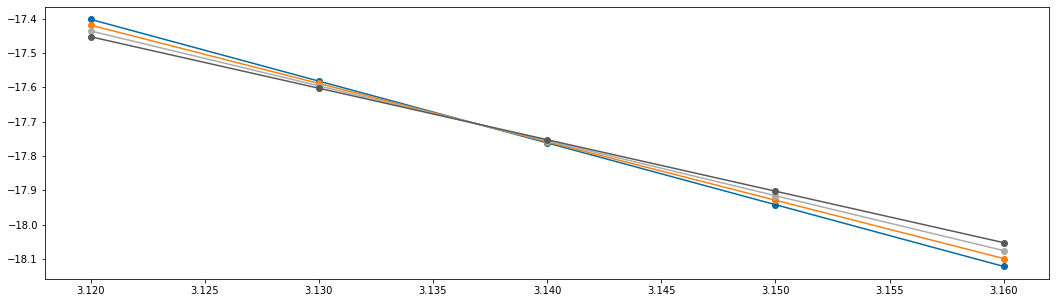

In [138]:
import os
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

structure_low_0 = np.array([0,1]*18)
structure_low_1 = np.array([0,1]*17+[1,0]*1)
structure_low_2 = build_discrete_vector(unique_config_2N[4])
structure_low_3 = build_discrete_vector(unique_config_3N[9])

species=[6,7]
parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]

Q_interaction = build_interaction_matrix_test(graphene_supercell, species, parameters = parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = 1)
Q_interaction = build_interaction_matrix_test(graphene_supercell, species, parameters = parameters, alpha=1, max_neigh = 1)

E_0, E_1, E_2, E_3 = [], [], [], []

potential_range = np.arange(3.12,3.16,0.01)

for potential in potential_range:
    Q_constraint = build_qubo_discrete_constraints(graphene_supercell,[6,7],chem_potential=[0,-potential],lambda_1 = 0, theta=0)
    Q = Q_interaction+Q_constraint
    #Q = Q_constraint
    E_0.append(classical_energy(structure_low_0,Q))
    E_1.append(classical_energy(structure_low_1,Q))
    E_2.append(classical_energy(structure_low_2,Q))
    E_3.append(classical_energy(structure_low_3,Q))


fig, axs = plt.subplots(1,1,figsize=(18, 5), sharey=False)

axs.plot(potential_range,E_0,"-o") 
axs.plot(potential_range,E_1,"-o") 
axs.plot(potential_range,E_2,"-o") 
axs.plot(potential_range,E_3,"-o") 


In [142]:
view(AseAtomsAdaptor().get_atoms(graphit))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [144]:
np.math.factorial(18)/(np.math.factorial(15)*np.math.factorial())

816.0

# <a id='anneal'>Run the anneal</a>

### Interaction energy

In [7]:
species=[6,7]
parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]

Q_interaction = build_interaction_matrix(structure, species, parameters = parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = 2)
Q_interaction = build_interaction_matrix(structure, species, parameters = parameters, alpha=1, max_neigh = 1)

#np.round(Q_interaction,5)[0:20,0:20]

### Concentration constraint

In [8]:
n_N = 1
n_sites = graphene_supercell.num_sites
n_C = n_sites-n_N
Q_constraint = build_qubo_discrete_constraints(graphene_supercell,[6,7],concentration=[n_C,n_N],lambda_1 = 10, theta=100) 

### Chemical potential

In [119]:
Q_constraint = build_qubo_discrete_constraints(graphene_supercell,[6,7],chem_potential=[0,-2],lambda_1 = 2, theta=10)
Q_constraint

array([[-10.,  20.,   0., ...,   0.,   0.,   0.],
       [  0., -12.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., -10., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., -12.,   0.,   0.],
       [  0.,   0.,   0., ...,   0., -10.,  20.],
       [  0.,   0.,   0., ...,   0.,   0., -12.]])

### Full Q

In [9]:
Q = Q_interaction + Q_constraint
Q

array([[-430.        ,  200.        ,   20.        , ...,    0.        ,
          20.        ,    0.        ],
       [   0.        , -110.        ,    0.        , ...,   20.        ,
           0.        ,   20.        ],
       [   0.        ,    0.        , -430.        , ...,   -6.00706603,
          20.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., -110.        ,
           0.        ,   20.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
        -430.        ,  200.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , -110.        ]])

In [137]:
n_N = 1
n_sites = graphene_supercell.num_sites
n_C = n_sites-n_N
x = np.array([0,1]*n_N+[1,0]*n_C)
classical_energy(x,Q_interaction)

-181.25814197059543

In [138]:
classical_energy(x,Q_constraint)#+classical_energy(x,Q_interaction)

-4700.0

### Run anneal

In [10]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler())

sampleset = sampler.sample_qubo(Q, num_reads=1000)

In [72]:
ddf = find_symmetry_equivalent_structures(convert_discrete_df(sampleset.to_pandas_dataframe(),2),graphene_supercell,vacancies=n_N)

KeyError: "['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '526', '527', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571', '572', '573', '574', '575', '576', '577', '578', '579', '580', '581', '582', '583', '584', '585', '586', '587', '588', '589', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '600', '601', '602', '603', '604', '605', '606', '607', '608', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638', '639', '640', '641', '642', '643', '644', '645', '646', '647', '648', '649', '650', '651', '652', '653', '654', '655', '656', '657', '658', '659', '660', '661', '662', '663', '664', '665', '666', '667', '668', '669', '670', '671', '672', '673', '674', '675', '676', '677', '678', '680', '681', '682', '683', '684', '685', '686', '687', '688', '691', '692', '693', '694', '695', '696', '697', '698', '699', '700', '701', '702', '703', '704', '705', '706', '707', '708', '709', '710', '711', '712', '713', '714', '715', '716', '717', '718', '719', '720', '721', '722', '723', '724', '725', '726', '727', '728', '729', '730', '731', '732', '733', '734', '735', '736', '737', '738', '739', '740', '741', '742', '743', '744', '745', '746', '747', '748', '749', '750', '751', '752', '753', '754', '755', '756', '757', '758', '759', '760', '761', '762', '763', '764', '765', '766', '767', '768', '769', '770', '771', '772', '773', '774', '775', '776', '777', '778', '779', '780', '781', '782', '783', '784', '785', '786', '787', '788', '789', '790', '791', '792', '793', '794', '795', '796', '797', '798', '799', '800', '801', '802', '803', '804', '805', '806', '807', '809', '810', '811', '812', '813', '814', '815', '816', '817', '818', '819', '820', '821', '822', '823', '824', '825', '826', '827', '829', '830', '831', '832', '833', '834', '835', '836', '837', '838', '839', '840', '841', '842', '843', '844', '845', '846', '847', '848', '849', '850', '851', '852', '853', '854', '855', '856', '857', '858', '859', '860', '861', '862', '863', '864', '865', '866', '867', '869', '870', '871', '872', '873', '874', '875', '876', '877', '878', '879', '880', '881', '882', '883', '884', '885', '886', '887', '888', '889', '890', '891', '892', '893', '894', '895', '896', '897', '898', '899', '900', '901', '902', '903', '904', '905', '906', '907', '908', '909', '910', '911', '912', '913', '914'] not found in axis"

In [337]:
ddf = convert_discrete_df_test(sampleset.to_pandas_dataframe(),[0,6])

In [333]:
def df2structure(df,structure):
    
    num_sites = structure.num_sites
    lattice = structure.lattice
    atom_position = structure.cart_coords
    
    configurations = df.iloc[:,0:num_sites].to_numpy()
    
    zero_elements = np.where(configurations == 0) 
    vacancies = False
    if len(zero_elements[0]) > 0:
        configurations[zero_elements] = 99
        vacancies = True
    
    all_structures = []
    for config in configurations:
        all_structures.append(Structure(lattice, config, atom_position, coords_are_cartesian=True))
    
    if vacancies == True:
        for structure in all_structures:
            structure.remove_species([99])
    
    return all_structures

In [262]:
[x.coords for x in structure.get_all_neighbors(3,sites=[graphene_supercell.sites[0]])[0]]

[array([ 4.32731759e-17, -1.42474120e+00,  0.00000000e+00]),
 array([-1.23386207, -0.7123706 ,  0.        ]),
 array([8.63144486e-16, 1.42474120e+00, 0.00000000e+00]),
 array([-1.11394291e-16,  2.84948239e+00,  0.00000000e+00]),
 array([-1.23386207,  0.7123706 ,  0.        ]),
 array([ 3.70158621, -0.7123706 ,  0.        ]),
 array([ 1.23386207, -0.7123706 ,  0.        ]),
 array([ 2.46772414, -1.4247412 ,  0.        ]),
 array([2.46772414, 1.4247412 , 0.        ]),
 array([3.70158621, 0.7123706 , 0.        ]),
 array([2.46772414, 2.84948239, 0.        ]),
 array([1.23386207, 3.56185299, 0.        ])]

In [278]:
vview(graphene_supercell)

In [323]:
find_symmetry_equivalent_structures_test(ddf,graphene_supercell,[6,7],[17,1])

TypeError: find_symmetry_equivalent_structures() takes from 2 to 3 positional arguments but 4 were given

In [324]:
find_symmetry_equivalent_structures(ddf, graphene_supercell, vacancies=1)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,0.00372,-4881.258142,112


# <a id='workflow'>New workflow</a>

In [26]:
# Get the DF
dataframe  = sampleset.to_pandas_dataframe()
# convert the df
df = convert_df_binary2atom_discrete(dataframe,[7,6])
# remove unfeasible
ddf = remove_unfeasible_solutions(df, [7,6],[1,17])
# find symmetry equivalent
find_symmetry_equivalent_structures(df,structure,remove_unfeasible=True,species=[7,6],concentration=[1,17])
# THINK ABOUT % OCCURRENCE AND CHAIN BREAK (Keep count and not %)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,6,6,6,6,6,7,6,6,6,6,...,6,6,6,6,6,6,6,0.002809,-4881.258142,178


In [317]:
def find_symmetry_equivalent_structures_test2(dataframe, structure, vacancies=None):
    #New descriptor-based version

    import copy 

    df = dataframe

    if vacancies is not None and type(vacancies) is int:
        num_atoms = sum([str(x).isdigit() for x in df.columns]) 
        all_config = df.iloc[:,0:num_atoms].to_numpy()
        sum_vector = np.sum(all_config,axis=1)
        feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        df = df.iloc[feasible_config,:]
    
    num_sites = structure.num_sites
    configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = df['num_occurrences'].to_numpy()
    chain_break = df['chain_break_fraction'].to_numpy()
    energies = df['energy'].to_numpy()
    
    #Replace the C atom with an H atom where the vacancies are
    all_structures = []
    for config in configurations:
        structure_2 = copy.deepcopy(structure)
        for j in np.where(config == 0)[0]:
            structure_2.replace(j,1)
        all_structures.append(structure_2)
    
    #Build the descriptor
    descriptor = build_descriptor(all_structures)

    descriptor_unique, descriptor_first, descriptor_count = \
    np.unique(descriptor, axis=0,return_counts=True, return_index=True)
    group_structures = []
    for desc in descriptor_unique:
        structure_desc = []
        for i,d in enumerate(descriptor):
            if np.all(np.array(desc) == np.array(d)):
                structure_desc.append(i)
        group_structures.append(structure_desc)
    
    unique_multiplicity = []
    unique_chain_break = []
    unique_structure_index = []
    
    for x in group_structures:
        unique_structure_index.append(x[0])
        unique_multiplicity.append(np.sum(multiplicity[x]))
        unique_chain_break.append(np.average(chain_break[x],weights=multiplicity[x]))    
    
    df = df.iloc[unique_structure_index].copy()
    if len(df) == len(unique_multiplicity):
        df['num_occurrences'] = unique_multiplicity
        df['chain_break_fraction'] = unique_chain_break
        
        return df
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None

In [341]:
def find_symmetry_equivalent_structures_test(dataframe, structure, remove_unfeasible = False, species=None ,concentration=None,):
    #New descriptor-based version
    
    #Concentration follows the order given in species
    
    import copy 

    df = dataframe
    
    num_sites = structure.num_sites
    lattice = structure.lattice
    atom_position = structure.cart_coords
    
    '''if concentration is not None and species is not None:
        feasible_config = []
        all_config = df.iloc[:,0:num_sites].to_numpy()
        #sum_vector = np.sum(all_config,axis=1)
        #feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        for config in all_config:
            feasible = True
            for i in range(len(concentration)):
                feasible *= np.sum(config == species[i]) == concentration[i] 
            #print(feasible)
            feasible_config.append(feasible) 
        
        df = df.iloc[feasible_config,:]'''
    
    if remove_unfeasible == True and species is not None and concentration is not None:
        df = remove_unfeasible(dataframe,species,concentration)
    
    #configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = df['num_occurrences'].to_numpy()
    chain_break = df['chain_break_fraction'].to_numpy()
    energies = df['energy'].to_numpy()


    '''#Replace the C atom with an H atom where the vacancies are
    zero_elements = np.where(configurations == 0) 
    configurations[zero_elements] = 99'''
    
    all_structures = df2structure(df,structure)
    '''for config in configurations:
        all_structures.append(Structure(lattice, config, atom_position, coords_are_cartesian=True))'''

    
    '''#Build the descriptor - WIP
    descriptor = build_descriptor(all_structures)

    descriptor_unique, descriptor_first, descriptor_count = \
    np.unique(descriptor, axis=0,return_counts=True, return_index=True)

    group_structures = []
    for desc in descriptor_unique:
        structure_desc = []
        for i,d in enumerate(descriptor):
            if np.all(np.array(desc) == np.array(d)):
                structure_desc.append(i)
        group_structures.append(structure_desc)'''
    '''for structure in all_structures:
        SpacegroupAnalyzer()
    
    unique_multiplicity = []
    unique_chain_break = []
    unique_structure_index = []
    
    for x in group_structures:
        unique_structure_index.append(x[0])
        unique_multiplicity.append(np.sum(multiplicity[x]))
        unique_chain_break.append(np.average(chain_break[x],weights=multiplicity[x]))    
    
    df = df.iloc[unique_structure_index].copy()
    
    if len(df) == len(unique_multiplicity):
        df['num_occurrences'] = unique_multiplicity
        df['chain_break_fraction'] = unique_chain_break
        
        return df
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None'''
    
    #Find the unique structures
    unique_structures = StructureMatcher().group_structures(all_structures)
    
    unique_structures_label = []
    
    #Find to which class the structures belong to
    for structure in all_structures:
        for i in range(len(unique_structures)):
            #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
            if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
                unique_structures_label.append(i)
                break
    
    unique_structures_label = np.array(unique_structures_label)
    unique_multiplicity = []
    unique_chain_break = []
    for x in range(len(unique_structures)):
        multiplicity_tmp = multiplicity[np.where(unique_structures_label==x)[0]]
        unique_multiplicity.append(np.sum(multiplicity_tmp))
        unique_chain_break.append(np.average(chain_break[np.where(unique_structures_label==x)[0]],weights=multiplicity_tmp))
    
    df = df.iloc[np.unique(unique_structures_label,return_index=True)[1]]
    
    if len(df) == len(unique_multiplicity):
        df1 = df.copy(deep=True)
        df1['num_occurrences'] = unique_multiplicity
        df1['chain_break_fraction'] = unique_chain_break
        
        return df1
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None
    
    
    

In [312]:
def build_descriptor(structures, max_radius=1.5):
    
    structure = structures[0]

    the_descriptor = []

    for i in range(structure.num_sites):
        site_distance = []
        unit_cell_neighbour = []
        centered_cart_coords = []
        #print(i,len(structure.get_all_neighbors(max_radius,sites=[structure.sites[i]])[0]))
        for site in structure.get_all_neighbors(max_radius,sites=[structure.sites[i]])[0]:
            site_distance.append(site.distance(structure.sites[i]))
            centered_cart_coords.append(site.coords-structure.cart_coords[i])


            for j,site2 in enumerate(structure.sites):
                if site.is_periodic_image(site2) == True:
                    unit_cell_neighbour.append(j)

        unit_cell_neighbour = np.array(unit_cell_neighbour)

        centered_sph_coords = cart2sph_array(centered_cart_coords)

        spatial_distribution = np.argsort(np.array(centered_sph_coords)[:,0]*100+\
                                          np.array(centered_sph_coords)[:,1]*10 +\
                                          np.array(centered_sph_coords)[:,2])

        the_descriptor.append(unit_cell_neighbour[spatial_distribution])
        #print(site,unit_cell_neighbour[spatial_distribution])
    the_descriptor = np.array(the_descriptor)
    #print(the_descriptor)
    
    descriptor_atom_number = []
    descriptor_sorted = []
    neighbours_spatial_dist_all = []



    for structure in structures:
        #print('here')
        #print(np.array(structure.atomic_numbers)[the_descriptor]) 
        #descriptor_sorted.append(np.array(structure.atomic_numbers)[the_descriptor][np.argsort(structure.atomic_numbers),:])
        #descriptor_non_sorted.append(np.array(structure.atomic_numbers)[the_descriptor])

        neighbours_spatial_dist_all.append(np.c_[structure.atomic_numbers,np.array(structure.atomic_numbers)[the_descriptor][np.argsort(structure.atomic_numbers),:]])  
    neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)

    #Sort
    neighbours_spatial_dist_all_sorted = []
    sorting = []

    for k,structure in enumerate(structures):
        sorted_atoms = []
        for i in range(len(neighbours_spatial_dist_all[0])):
            sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
        sorting.append(np.argsort(np.array(sorted_atoms)))    
        neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
    neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)    

    #Slice
    neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]

    #Flatten
    n_structures = neighbours_spatial_dist_all_sorted_sliced.shape[0]
    vector_len = neighbours_spatial_dist_all_sorted_sliced.shape[1] * neighbours_spatial_dist_all_sorted_sliced.shape[2]
    neighbours_spatial_dist_all_sorted_sliced_flat = \
    np.reshape(neighbours_spatial_dist_all_sorted_sliced, [n_structures,vector_len])

    #Reduce

    return neighbours_spatial_dist_all_sorted_sliced_flat  

In [222]:
def cart2sph_array(array):
    sph_coordinates = []
    for line in array:
        x = line[0]
        y = line[1]
        z = line[2]
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        el = np.arctan2(z, hxy)
        az = np.arctan2(y, x)
        if np.around(az,6) ==  np.around(2*np.pi,6) \
        or np.around(az,6) ==  -np.around(2*np.pi,6):
            az = 0.
        if np.around(az,6) < 0.:
            az = np.round(2*np.pi+az,6)
        sph_coordinates.append([round(r,6), round(el,6), round(az,6) ])   
    return sph_coordinates

In [325]:
def convert_discrete_df_test(dataframe,species,remove_unfeasible=True):
    
    num_species = len(species)
    
    df  = copy.deepcopy(dataframe)
    
    if type(df.columns[0]) is str:
        num_sites = int(sum([x.isdigit() for x in df.columns])/num_species)
    else:
        num_sites = int(sum([type(x) == int for x in dataframe.columns])/num_species)
    
    sites = df.iloc[:,0:num_sites].to_numpy()

    test_sum = sites[:,::num_species]

    for i in range(1,2):
        test_sum += sites[:,i::num_species]
    
    
    unfeasible = np.where(np.prod(test_sum,axis=1) != 1)[0]
    if isinstance(df.index[0], str): 
        unfeasible = [str(x) for x in unfeasible]
    elif isinstance(df.index[0], int):
        unfeasible = [int(x) for x in unfeasible]

    df.drop(unfeasible, inplace=True)
    
    convert = lambda x: np.array(species)[x]
    
    labels = df.iloc[:,0:num_sites*num_species].to_numpy()[:,::num_species]
    new_labels = convert(labels)
    if isinstance(df.columns[0], int): 
        columns_drop = [int(x) for x in np.arange(num_sites,num_sites*num_species)]
    elif isinstance(df.columns[0], str):
        columns_drop = [str(x) for x in np.arange(num_sites,num_sites*num_species)]

    
    df_1 = df.drop(columns_drop,axis=1,inplace=False)

    for i in range(new_labels.shape[1]):
        if isinstance(df.columns[0], int):
            df_1.loc[:,int(i)] = new_labels[:,i]
        elif isinstance(df.columns[0], str):
            df_1.loc[:,str(i)] = new_labels[:,i]
    
    return df_1

### + 1 vacancy

In [199]:
species=[6,7]
parameters = [[E_CC,E_CN,0,E_NN,0,0]]
#chem_potential = [0.5,0]
bqm = build_quadratic_model_discrete(structure ,species, parameters,
    concentration = [15,2,1], chem_potential=None, max_neigh = 1, alpha=10,lambda_1 = 10, theta=1000)
build_qubo_matrix(bqm)

array([[-1290.        ,  2000.        ,    20.        , ...,
            0.        ,    20.        ,     0.        ],
       [    0.        , -1030.        ,     0.        , ...,
           20.        ,     0.        ,    20.        ],
       [    0.        ,     0.        , -1290.        , ...,
           -6.01136229,    20.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
        -1030.        ,     0.        ,    20.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        , -1290.        ,  2000.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        , -1030.        ]])

# Test parameters

In [22]:
from dimod.binary import BinaryQuadraticModel
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.embedding.chain_strength import  uniform_torque_compensation
from dimod.binary import BinaryQuadraticModel
import dwave.inspector


In [28]:
file_path = './data/discrete/test_parameters'
parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
for n_N in [1]:
    n_C = structure.num_sites - n_N
    #for ratio_lambda in [1,5,10]:
    for ratio_lambda in range(1,11):
        #for ratio_theta in range(1,11):
        for ratio_theta in range(1,11):
            #q1 = build_interaction_matrix_test(structure, species, parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = 1)
            q1 = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)
            lambda_1 = np.max(np.abs(q1))*ratio_lambda
            #theta = lambda_1*ratio_theta
            theta = np.max(np.abs(q1))*ratio_theta
            q2 = build_qubo_discrete_constraints(structure,[6,7],concentration=[n_C,n_N],lambda_1 = lambda_1, theta=theta) 
            Q= q1+q2
            
            sampler = EmbeddingComposite(DWaveSampler())
            
            
            bqm = BinaryQuadraticModel.from_qubo(Q)
            
            chain_strength = uniform_torque_compensation(bqm)
            print(ratio_lambda,ratio_theta,chain_strength)
            sampleset = sampler.sample(bqm, chain_strength=chain_strength,num_reads=1000)
            
            save_json_discrete(structure,sampleset, bqm, n_dopant_atom=n_N, lambda_1 = ratio_lambda, theta = ratio_theta, 
                             label='Test anneal', file_path = file_path, file_name = 'Ngraphene', save_qubo = True,
                            chain_strength = chain_strength)

            

1 1 18.311493875921016
1 2 19.615047852157232
1 3 21.613628247781385
1 4 24.13518757624469
1 5 27.03377817035734
1 6 30.201035983952814
1 7 33.560982052977636
1 8 37.06124644062732
1 9 40.665611868283584
1 10 44.34870369049369
2 1 34.741076350998966
2 2 35.44547475067115
2 3 36.58934959918449
2 4 38.133172663687056
2 5 40.03069747359078
2 6 42.2342769863777
2 7 44.6986699401486
2 8 47.383199193289634
2 9 50.25259761126715
2 10 53.27700345444786
3 1 51.37008824074505
3 2 51.84906228791856
3 3 52.63766791877593
3 4 53.7222713335406
3 5 55.08539116733343
3 6 56.706946068343875
3 7 58.56547339733827
3 8 60.63918820059318
3 9 62.90681319631385
3 10 65.3481650616239
4 1 68.05249111881118
4 2 68.41477064019436
4 3 69.01434391154694
4 4 69.84510017781135
4 5 70.89891326157321
4 6 72.16601218033324
4 7 73.63538725278957
4 8 75.29519723887381
4 9 77.13314934663234
4 10 79.13683250254093
5 1 84.7567645139181
5 2 85.04791840569816
5 3 85.53097245403657
5 4 86.20270066674473
5 5 87.05873583428584
5

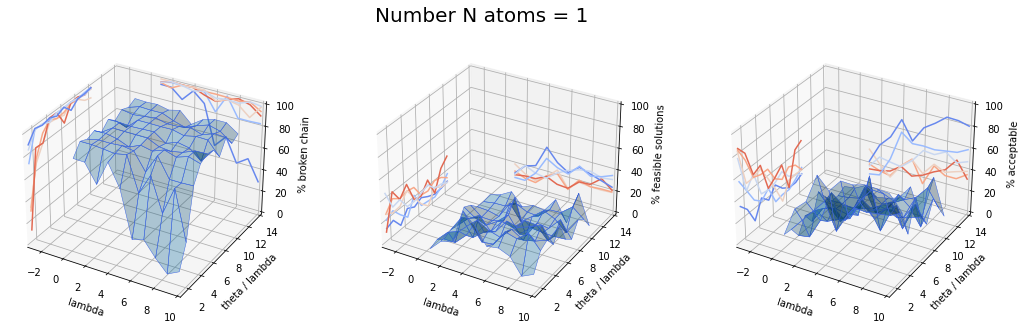

In [30]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/test_parameters/no_ratio/prefactor_0.3/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']

num_reads = 1000

x = np.arange(1,11)
y = np.arange(1,11)

#x = np.array([1,5,10])
#y = np.array([1,5,10])

X = np.zeros(((len(x),len(y))))
Y = np.zeros(((len(x),len(y))))
for i in range(len(y)):
    X[i,:] = x
for i in range(len(x)):
    Y[:,i] = y  


for i,vac in enumerate([1]):  
    num_C = 18 - vac
    z1, z2, z3 = np.zeros((len(x),len(y))), np.zeros((len(x),len(y))), np.zeros((len(x),len(y)))
    #directory = os.path.join(directory_main,sub_directory[i])
    directory = directory_main
    fig = plt.figure(figsize=(18, 5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    #ax = plt.figure().add_subplot(projection='3d')
    #fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False, projection='3d')
    fig.suptitle('Number N atoms = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for j,ratio_l in enumerate(x):
        for k,ratio_t in enumerate(y):
            #print(ratio_l,ratio_t)
            df_list = []
            df_discrete_list = []
            ratio_broken_chains_tmp = []
            ratio_feasible_tmp = []
            energy_distribution_tmp = []

            for filename in os.listdir(directory):
                f = os.path.join(directory, filename)
                if os.path.isfile(f) and f.endswith(".json") and '_l%s_'%ratio_l in f \
                            and '_t%s_'%ratio_t in f and '_%s_'%vac in f:
                    #print(f)
                    df_discrete, param = load_json(f,return_param = True, return_qubo = False)
                    df_discrete_list.append(df_discrete)
                    df = convert_discrete_df(df_discrete,2)
                    df_list.append(df)
            #print(len(df_list))
            df = pd.concat(df_list)
            df_discrete = pd.concat(df_discrete_list)
            z1[j,k] = find_ratio_broken_chains(df)*100
            z2[j,k] = find_ratio_feasible_discrete(df_discrete,[num_C,vac],[6,7])*100
            #z3[j,k] = float(param.loc['chain_strength'])
            z3[j,k] = find_ratio_acceptable(df_discrete,2)*100
            
            

    # Plot the 3D surface
    ax.plot_surface(X, Y, z1, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                    alpha=0.3)


    ax.contour(X, Y, z1, zdir='x', offset=x[0]-4, cmap='coolwarm')
    ax.contour(X, Y, z1, zdir='y', offset=y[-1]+4, cmap='coolwarm')
    #ax.contour(X, Y, z1, zdir='z', offset=0, cmap='coolwarm')
    ax.set(xlim=(x[0]-4,x[-1]), ylim=(y[0],y[-1]+4), zlim=(0, 100),
           xlabel='lambda', ylabel='theta / lambda', zlabel='% broken chain')
    
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.plot_surface(X, Y, z2, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                    alpha=0.3)

    
    ax.contour(X, Y, z2, zdir='x', offset=x[0]-4, cmap='coolwarm')
    ax.contour(X, Y, z2, zdir='y', offset=y[-1]+4, cmap='coolwarm')
    #ax.contour(X, Y, z2, zdir='z', offset=-100, cmap='coolwarm')
    ax.set(xlim=(x[0]-4,x[-1]), ylim=(y[0],y[-1]+4), zlim=(0, 100),
           xlabel='lambda', ylabel='theta / lambda', zlabel='% feasible solutions')
    

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot_surface(X, Y, z3, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1,
                    alpha=0.3)

    
    ax.contour(X, Y, z3, zdir='x', offset=x[0]-4, cmap='coolwarm')
    ax.contour(X, Y, z3, zdir='y', offset=y[-1]+4, cmap='coolwarm')
    #ax.contour(X, Y, z2, zdir='z', offset=-100, cmap='coolwarm')
    ax.set(xlim=(x[0]-4,x[-1]), ylim=(y[0],y[-1]+4), zlim=(0, 100),
           xlabel='lambda', ylabel='theta / lambda', zlabel='% acceptable')
    plt.show()
    
    '''
    axs[0].set_ylabel('% broken chains', fontsize=16)
    axs[1].set_ylabel('% feasible solutions', fontsize=16)
    axs[2].set_ylabel('% states', fontsize=16)

    axs[2].legend()

    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\lambda / \alpha$', fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/alpha_lamdba_graphs_%s.png'%str(vac),dpi=200)'''
#print(z2)

# Test potential

In [8]:
from dimod.binary import BinaryQuadraticModel
from dwave.system import EmbeddingComposite, DWaveSampler
from dwave.embedding.chain_strength import  uniform_torque_compensation
from dimod.binary import BinaryQuadraticModel
import dwave.inspector
import csv


In [89]:
file_path = './data/discrete/test_potential/test_scaled_all_pot/'
parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
potential_range_1 = np.arange(-10.,11,1.)
potential_range = []
theta_range = []
for theta in [10]:
    n_C = structure.num_sites - n_N
    potential_range = []
    for i,potential in enumerate(potential_range_1):
        
        q1 = build_interaction_matrix(structure, [6,7], parameters, alpha=1, max_neigh = 1)
        potential = potential*np.max(np.abs(q1))
        potential_range.append(potential)

        chem_potential = [0,potential]
        theta_scaled = theta + np.max(np.abs(potential))
        theta_range.append(theta)
        q2 = build_qubo_discrete_constraints(structure,[6,7],chem_potential=chem_potential, theta=theta_scaled) 
        print(theta_scaled,potential)
        Q= q1+q2

        sampler = EmbeddingComposite(DWaveSampler())

        bqm = BinaryQuadraticModel.from_qubo(Q)

        chain_strength = uniform_torque_compensation(bqm, prefactor=0.3)

        sampleset = sampler.sample(bqm, chain_strength=chain_strength,num_reads=1000)

        save_json_discrete_potential(structure,sampleset, bqm, theta = theta, index = str(i),
                         label='Test anneal', file_path = file_path, file_name = 'Ngraphene', save_qubo = True,
                        chain_strength = chain_strength, potential=potential)



with open(file_path+'potential_range.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(potential_range)


24.35476538932562 -14.354765389325621
22.91928885039306 -12.919288850393059
21.483812311460497 -11.483812311460497
20.048335772527935 -10.048335772527935
18.612859233595373 -8.612859233595373
17.17738269466281 -7.1773826946628105
15.741906155730248 -5.741906155730248
14.306429616797686 -4.306429616797686
12.870953077865124 -2.870953077865124
11.435476538932562 -1.435476538932562
10.0 0.0
11.435476538932562 1.435476538932562
12.870953077865124 2.870953077865124
14.306429616797686 4.306429616797686
15.741906155730248 5.741906155730248
17.17738269466281 7.1773826946628105
18.612859233595373 8.612859233595373
20.048335772527935 10.048335772527935
21.483812311460497 11.483812311460497
22.91928885039306 12.919288850393059
24.35476538932562 14.354765389325621


In [133]:
np.round(q1,2)[0:20,0:20]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.37, 0.39],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 1.44],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.37, 0.39],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 1.44],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.37, 0.39],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0. 

In [134]:
convert_discrete_df(load_json('./data/discrete/test_potential/Ngraphene_C18_bqm_i10_t10_r1000_t0_1677580366.json')[0],2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,0,1,1,0,1,...,1,1,1,1,1,1,1,0.000000,-248.188488,1
1,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000000,-248.188488,1
2,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,0.000000,-248.188488,1
3,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.000000,-248.188488,1
4,1,1,1,1,0,1,1,1,1,1,...,0,1,1,1,1,1,1,0.000000,-248.188488,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0,0,1,0,1,1,0,1,0,1,...,1,1,1,0,0,1,1,0.000000,-225.157027,1
990,0,0,0,0,1,1,0,0,1,1,...,0,1,1,1,1,1,1,0.027778,-245.893838,1
993,1,0,1,1,1,0,1,0,0,0,...,1,1,0,1,1,1,1,0.027778,-228.278274,1
994,1,0,0,1,0,1,0,1,0,1,...,1,1,1,1,0,0,1,0.027778,-243.833868,1


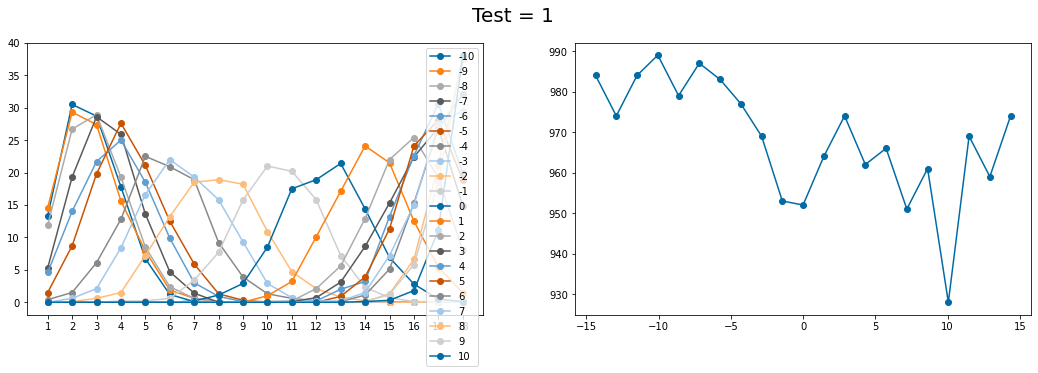

In [90]:
import os
import matplotlib.pyplot as plt
import csv
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/test_potential/test_scaled_all_pot/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = np.arange(-10,21,1)

#to make sure the lowest chain strength return results
#unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

with open(directory_main+'potential_range.csv', newline='') as f:
    reader = csv.reader(f)
    potential_range_tmp = list(reader)[0]
    potential_range = [float(x) for x in potential_range_tmp]

for i,vac in enumerate([1]):    
    directory = os.path.join(directory_main,sub_directory[i])
    directory = directory_main
    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('Test = %s'%vac, fontsize=20)
    
    total_multiplicity = []
    
    for j,potential in enumerate(potential_range):
        '''directory = os.path.join(directory_main,sub_directory[i])
        directory = directory_main
        fig, axs = plt.subplots(1,1,figsize=(10, 5), sharey=False)
        fig.suptitle('Test = %s'%vac, fontsize=20)'''
        #print(j)
        ratio_structures = []
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_i%s_'%j in f:
                df, param = load_json(f,return_param = True, return_qubo = False)
                total_reads = np.sum(df['num_occurrences'].to_numpy())
                df = convert_discrete_df(df,2)
                sum_vector = np.sum(df.iloc[:,0:18],axis=1)
                multiplicity = df['num_occurrences'].to_numpy()
                total_multiplicity.append(np.sum(multiplicity))
                
                for k in range(0,18):
                    ratio_structures.append((np.sum(multiplicity[np.where(sum_vector == k)])/total_reads)*100)
        #print(ratio_structures)
        axs[0].plot(np.arange(1,19),ratio_structures,'-o',label=x[j])#label=potential)
    axs[0].set_xticks(np.arange(1,19))
    axs[0].legend()
    axs[1].plot(potential_range,total_multiplicity,'-o')
    #axs[1].plot(potential_range,theta_range,'-o')
    plt.show
    

# TEST THETA

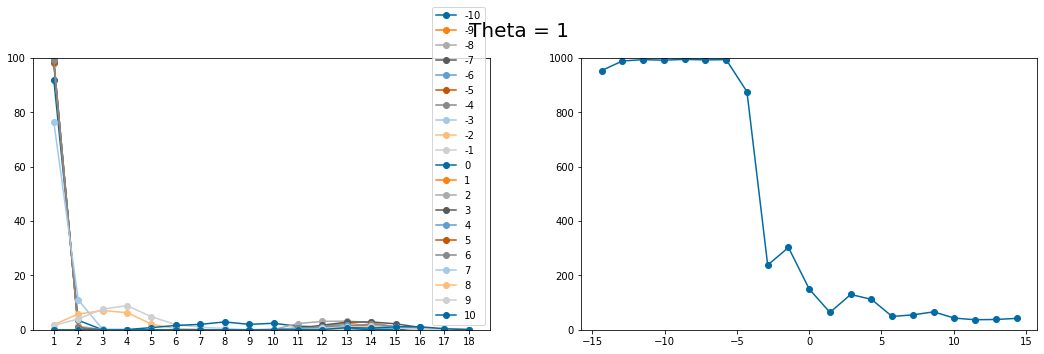

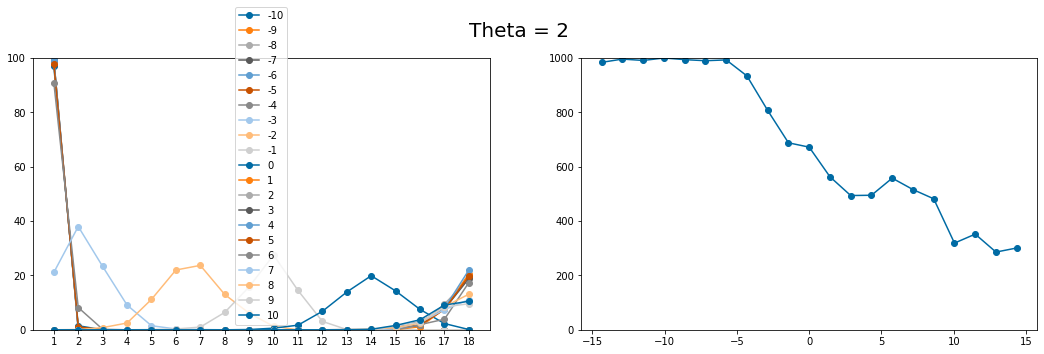

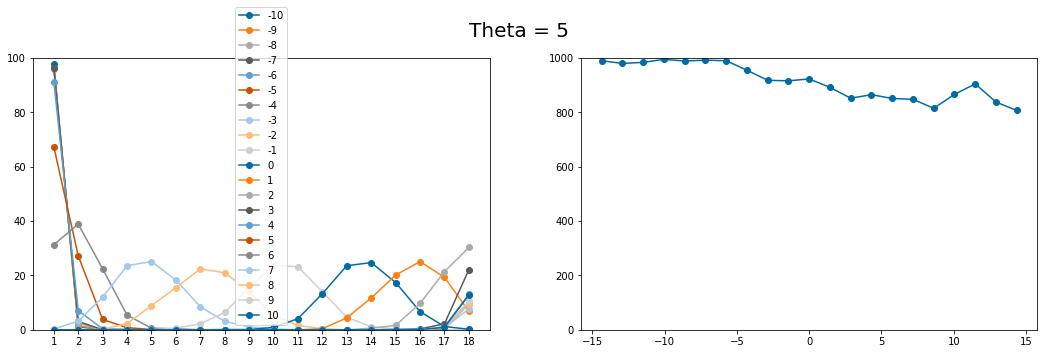

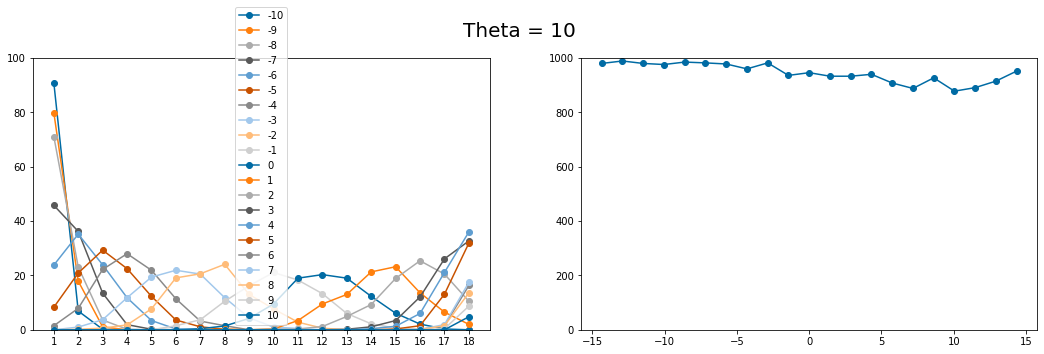

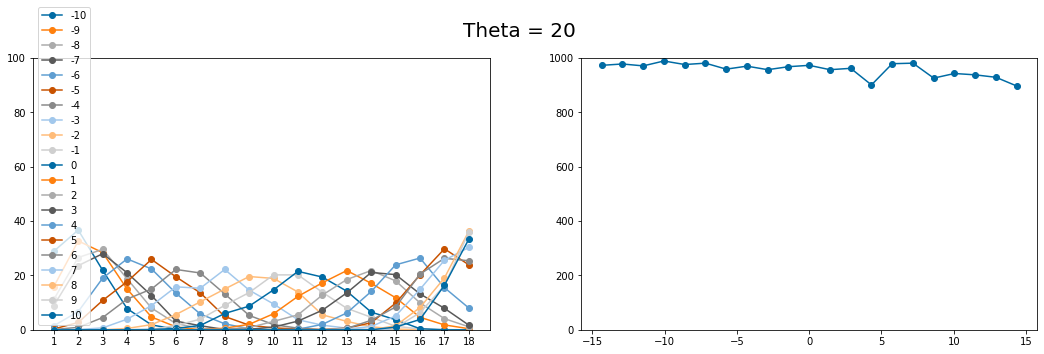

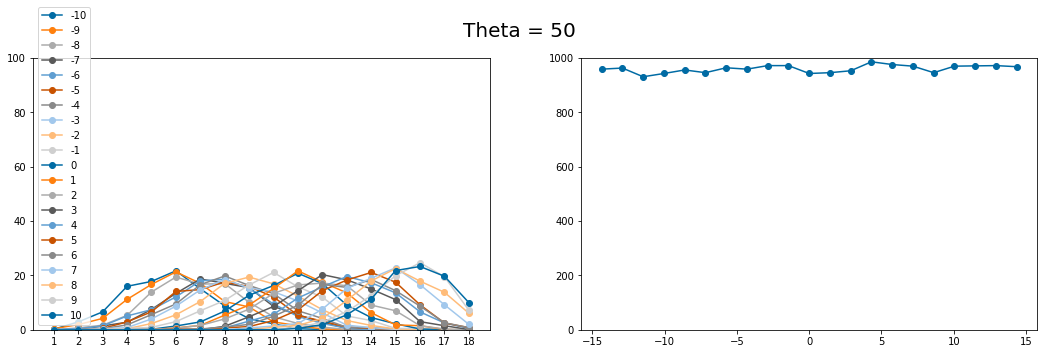

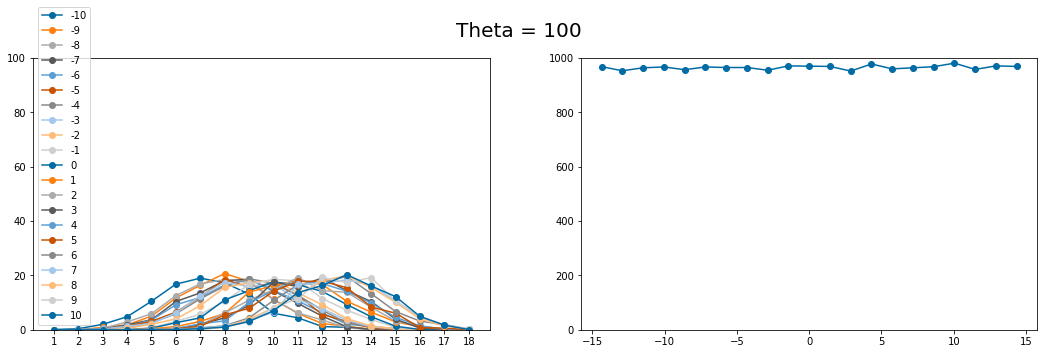

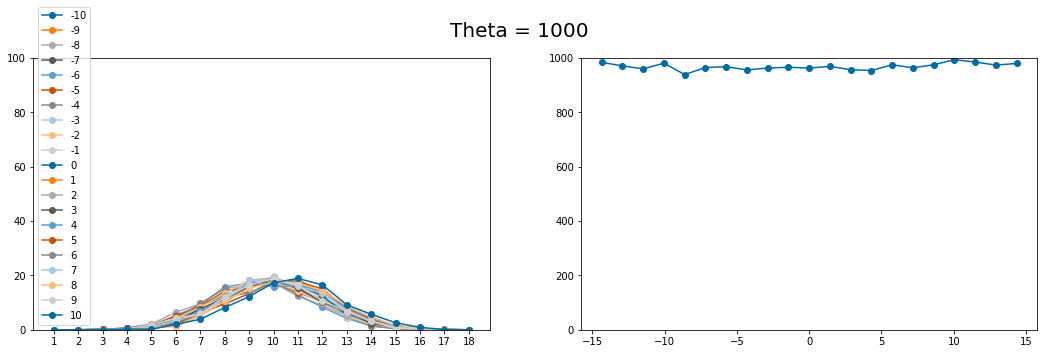

In [97]:
import os
import matplotlib.pyplot as plt
import csv
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/discrete/test_potential/test_tall_all_pot/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = np.arange(-10,21,1)

#to make sure the lowest chain strength return results
#unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

with open(directory_main+'potential_range.csv', newline='') as f:
    reader = csv.reader(f)
    potential_range_tmp = list(reader)[0]
    potential_range = [float(x) for x in potential_range_tmp]

for i,theta in enumerate([1,2,5,10,20,50,100,1000]):    
    #directory = os.path.join(directory_main,sub_directory[i])
    directory = directory_main
    fig, axs = plt.subplots(1,2,figsize=(18, 5), sharey=False)
    fig.suptitle('Theta = %s'%theta, fontsize=20)
    
    total_multiplicity = []
    
    for j,potential in enumerate(potential_range):

        ratio_structures = []
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_i%s_'%j in f and '_t%s_'%theta in f:
                #print(f)
                df, param = load_json(f,return_param = True, return_qubo = False)
                total_reads = np.sum(df['num_occurrences'].to_numpy())
                df = convert_discrete_df(df,2)
                sum_vector = np.sum(df.iloc[:,0:18],axis=1)
                multiplicity = df['num_occurrences'].to_numpy()
                total_multiplicity.append(np.sum(multiplicity))
                
                for k in range(0,18):
                    ratio_structures.append((np.sum(multiplicity[np.where(sum_vector == k)])/total_reads)*100)
        #print(ratio_structures)
        axs[0].plot(np.arange(1,19),ratio_structures,'-o',label=x[j])#label=potential)
    axs[0].set_xticks(np.arange(1,19))
    axs[0].set_ylim([0,100])
    axs[1].set_ylim([0,1000])
    axs[0].legend()
    axs[1].plot(potential_range,total_multiplicity,'-o')
    #axs[1].plot(potential_range,theta_range,'-o')
    plt.show
    

In [67]:
ratio_structures

[]

In [44]:
ddf = load_json('./data/discrete/test_potential/test_t10_0/Ngraphene_C18_bqm_i0_t10_r1000_t0_1677761315.json')[0]
df = convert_discrete_df(ddf,2)
np.unique(np.sum(df.iloc[:,0:18].to_numpy(),axis=1),return_counts=True)
twelve = np.where(np.sum(df.iloc[:,0:18].to_numpy(),axis=1) == 12)
np.unique(df.iloc[twelve]['energy'])

array([-248.00074472, -246.97075937, -245.94077403, -244.91078868,
       -243.88080333, -233.81682229, -232.75554639, -228.32520964,
       -227.31086957])

In [29]:
np.unique(np.round(df['energy'],4))

array([-248.2354, -248.1885, -248.1416, -248.0946, -248.0477, -248.0007,
       -247.9538, -247.1116, -247.0646, -247.0177, -246.9708, -246.9238,
       -246.0346, -245.9877, -245.9408, -245.8938, -245.8469, -245.8   ,
       -245.0047, -244.9577, -244.9108, -244.8639, -244.8169, -244.77  ,
       -243.8808, -243.8339, -243.7869, -243.74  , -242.8039, -242.7569,
       -242.71  , -242.6631, -241.7739, -241.727 , -241.68  , -241.6331,
       -240.697 , -240.65  , -240.6031, -240.5562, -239.6201, -239.5731,
       -239.5262, -238.5901, -238.5431, -238.4962, -237.5131, -237.4662,
       -237.4193, -236.4832, -236.3893, -235.3593, -234.7842, -234.3293,
       -234.2824, -233.8168, -233.7542, -232.7555, -232.7399, -232.7086,
       -232.646 , -232.2224, -231.6943, -231.6004, -231.4777, -231.1455,
       -230.633 , -230.6173, -230.5861, -230.5391, -229.5561, -229.5248,
       -228.5574, -228.5417, -228.3252, -228.247 , -227.4961, -227.3109,
       -226.187 , -220.9432])

In [55]:
chem_potential=[0,-1]
theta= np.max(np.abs(np.array(chem_potential)))*2
q2 = build_qubo_discrete_constraints(graphene_supercell,[6,7],chem_potential=chem_potential, theta=theta) 
q2[0:2,0:2]

array([[-2.,  4.],
       [ 0., -3.]])

## Results analysis

# <a id='diamond'>Diamond</a>

In [99]:
diamond_gui = Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond.gui')
diamond = cry_gui2pmg(diamond_gui)
diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()

diamond_supercell_gui = Crystal_gui().read_cry_gui('./data/crystal/diamond/diamond_confcount_2.gui')
diamond_supercell = cry_gui2pmg(diamond_supercell_gui)
#diamond = SpacegroupAnalyzer(diamond).get_conventional_standard_structure()


'''n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
diamond_supercell = copy.deepcopy(diamond)
diamond_supercell.make_supercell(scaling_matrix)
diamond_supercell.num_sites'''


vview(diamond_supercell)
N_C = diamond_supercell.num_sites
N_C


54

### Diamond pure

In [100]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s.d12'%N_C)

#runcry('./data/crystal/graphene_%s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s.out'%N_C)
E_d = crystal_output.get_final_energy()

In [101]:
max_shell = 3
shells, n_atoms_shell = np.unique(np.round(diamond_supercell.distance_matrix[0],5),return_counts=True)
neighbours_sorted = np.argsort(diamond_supercell.distance_matrix[0])[1:]
n_atoms_shell[0] = 0
atoms_shell = []
for i in range(max_shell):
    begin = np.cumsum(n_atoms_shell)[i]
    end = np.cumsum(n_atoms_shell)[i+1]
    atoms_shell.append(neighbours_sorted[begin:end])

In [96]:
np.cumsum(n_atoms_shell)

array([ 0,  4, 16, 28, 31, 43, 55, 59, 62, 63])

In [136]:
folder = './data/crystal/diamond/interaction_energy/'
for shell in range(2):
    
    #print(atoms_shell[shell])
    
    structure = copy.deepcopy(diamond_supercell)
    structure.replace(0,7)
    neighbouring_atoms = np.argsort(structure.distance_matrix[0])[np.cumsum(n_atoms_shell)[shell]+1]
    print(neighbouring_atoms)
    structure.replace(neighbouring_atoms,7)
    a = SpacegroupAnalyzer(structure).get_symmetrized_structure()

    eq_positions = []
    eq_sites = []
    for j,k in enumerate(a.equivalent_indices):
        for i in atoms_shell[shell]:
            if i in k:
                #print(i,j)
                eq_sites.append(i)
                eq_positions.append(j)
    
    structure.replace(0,6)

    for n,m in enumerate(np.unique(eq_positions,return_index=True)[1][1:]):
        structure = copy.deepcopy(diamond_supercell)
        structure.replace(eq_sites[0],7)
        structure.replace(eq_sites[m],7) 
        #print(structure.distance_matrix[0][eq_sites[m]])
        structure_gui = cry_pmg2gui(structure)
        structure_gui.write_crystal_gui(folder+'diamond_%s_s%s_%s_%s.gui'%(str(N_C),str(shell+2),str(n),str(eq_positions[m])))
        
        print('diamond_%s_s%s_%s_%s.d12'%(str(N_C),str(shell+2),str(n),str(eq_positions[m])))

13
diamond_64_s2_0_5.d12
19
diamond_64_s3_0_1.d12
diamond_64_s3_1_2.d12
diamond_64_s3_2_10.d12
diamond_64_s3_3_11.d12
diamond_64_s3_4_13.d12
diamond_64_s3_5_14.d12


### Diamond 1 N

In [102]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_1N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_1N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_1N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_1N.out'%N_C)
E_d1N = crystal_output.get_final_energy()



### Diamond 2 N max dist

In [103]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[-1]
print(non_neighbouring_atoms)
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N.out'%N_C)
E_d2N = crystal_output.get_final_energy()



53


In [7]:
vview(structure)

### Diamond 2 N 2nd shell

In [104]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[5]
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2N2s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2N2s.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N2s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N2s.out'%N_C)
E_d2N2s = crystal_output.get_final_energy()


In [105]:
vview(structure)

### Diamond 2 N 3rd shell

In [106]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[11]
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2N3s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2N3s.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N2s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2N3s.out'%N_C)
E_d2N3s = crystal_output.get_final_energy()


### Diamond 2 N neighbours

In [107]:
crystal_input = Crystal_input().from_file('./data/crystal/diamond/diamond.d12')

structure = copy.deepcopy(diamond_supercell)
structure.replace(0,7)
neighbouring_atoms = np.argsort(structure.distance_matrix[0])[1]
structure.replace(neighbouring_atoms,7)


crystal_gui = cry_pmg2gui(structure,dimensionality=3)
crystal_gui.write_crystal_gui('./data/crystal/diamond/diamond_%s_2Nn.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/diamond/diamond_%s_2Nn.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2Nn'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/diamond/diamond_%s_2Nn.out'%N_C)
E_d2Nn = crystal_output.get_final_energy()



### Diamond all 2N configurations

In [188]:
new_atom = 'N'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/diamond/diamond_confcount_2.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/diamond/diamond_confcount_2.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_d_2 = []
C_atoms = []
N_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_d_2.append(new_structure)
    N_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    C_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

In [198]:
#Write files
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,structure in enumerate(structures_d_2):
    crystal_gui = cry_pmg2gui(structure)
    crystal_gui.write_crystal_gui('./data/crystal/diamond/2N/diamond_%s_2N_%s.gui'%(str(N_C),str(i)))
    sh.copy('./data/crystal/diamond/diamond.d12','./data/crystal/diamond/2N/diamond_%s_2N_%s.d12'%(str(N_C),str(i)))
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm diamond_%s_2N_%s\n'%(str(N_C),str(i)))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys diamond_%s_2N_%s'%(str(N_C),str(i)))
    data.append('\n\n')
    
with open('./data/crystal/diamond/2N/diamond_64_2N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)

### Diamond all 3N configurations

In [201]:
new_atom = 'N'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/diamond/diamond_confcount_3.out')

cry_output.get_config_analysis()

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/diamond/diamond_confcount_3.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_d_3 = []
C_atoms = []
N_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_d_3.append(new_structure)
    N_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    C_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

In [203]:
#Write files
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,structure in enumerate(structures_d_3):
    crystal_gui = cry_pmg2gui(structure)
    crystal_gui.write_crystal_gui('./data/crystal/diamond/3N/diamond_%s_3N_%s.gui'%(str(N_C),str(i)))
    sh.copy('./data/crystal/diamond/diamond.d12','./data/crystal/diamond/3N/diamond_%s_3N_%s.d12'%(str(N_C),str(i)))
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm diamond_%s_3N_%s\n'%(str(N_C),str(i)))
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys diamond_%s_3N_%s'%(str(N_C),str(i)))
    data.append('\n\n')
    
with open('./data/crystal/diamond/3N/diamond_64_3N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)

In [205]:
N_C

64

# <a id='dqm'>DQM</a>

In [31]:
parameters[0]

[0.374200641927153, 0.3898459172511745, 1.435476538932562]

In [86]:
def build_discrete_quadratic_model_test(structure,species, parameters, concentration = None, 
                                        potential = None,max_neigh = 1,):
    # structure = pymatgen Structure object
    # species = list of atomic numbers
    # interaction = interactomic potential given as a matrix element by row
    # concentrations = list of concentrations
    
    # https://github.com/dwave-examples/graph-partitioning
    
    from dimod import DiscreteQuadraticModel
    
    c = np.arange(structure.num_sites)    
    adjacency_matrix = build_adjacency_matrix(structure)    
    dqm = DiscreteQuadraticModel()     
    n_species = len(species)
    #concentration_1 = concentrations[0]
    
    #n_atoms_species = [int(np.rint(x*structure.num_sites)) for x in concentrations[:-1]]
    #n_atoms_species.append(int(np.rint(structure.num_sites-np.sum(c))))
   
    #Make this better (or input?)
    interaction_dict = {}
    index = -1
    for i in range(len(species)):
        for j in range(i,len(species)):
            index += 1
            interaction_dict[(i, j)] = parameters[index]
    
    #This creates a (num_sites*num_species) x (num_sites*num_species) matrix
    #DOES IT INCLUDE THE ONE-HOT ENCODING?
    
    for i in range(structure.num_sites):
        dqm.add_variable(n_species, label=i)
    
    #define linked atoms and bond strength
    for i in range(structure.num_sites):
        if potential != None:
            dqm.set_linear(i, potential)
        for j in np.where(adjacency_matrix[i] == 1)[0]:
            #dqm.set_quadratic(i, j, {(0, 0): cu_cu, (0, 1): cu_zn, (1, 1): zn_zn})
            dqm.set_quadratic(i, j, interaction_dict)
    
    # This imposes a double constraint (on both species)
    if concentration != None:
        for i,conc in enumerate(concentration):
            concentration_1_v = [(s,i,1) for s in c] #make loop

            #Define the concentration as a constraint
            dqm.add_linear_equality_constraint(
                        concentration_1_v,
                lagrange_multiplier=10.,
                        constant= -conc)
    
    
    return dqm

#dqm = build_discrete_quadratic_model_test(graphene_supercell,[6,7], parameters=parameters[0], potential=[0,-1], max_neigh = 1)
#dqm = build_discrete_quadratic_model_test(graphene_supercell,[6,7], parameters=parameters[0], concentration=[15,3], max_neigh = 1)



In [87]:
from dwave.system import LeapHybridDQMSampler

sampleset = LeapHybridDQMSampler().sample_dqm(dqm,
                label='Test graphene') 


In [88]:
np.unique(np.round(sampleset.to_pandas_dataframe()['energy'].to_numpy(),5))


array([10.24422, 11.27421])

In [89]:
sampleset.to_pandas_dataframe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,energy,num_occurrences
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,10.244225,1
1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,11.274210,1
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.244225,1
3,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,10.244225,1
4,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,10.244225,1
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,10.244225,1
6,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,11.274210,1
7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,11.274210,1
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,10.244225,1
9,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.244225,1


In [90]:
vview(graphene_supercell)

In [7]:
def build_interaction_matrix_test(structure, species, parameters, alpha=1, atomic_contribution=None, max_neigh = 1):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_sites = structure.num_sites
    num_species = len(species)
    num_elements = num_sites*num_species

    distance_matrix = np.round(structure.distance_matrix,5)
    shells = np.unique(np.round(distance_matrix,5))
    
    distance_matrix_filter = np.zeros((num_sites,num_sites),int)

    for i,s in enumerate(shells[0:max_neigh+1]):
        row_index = np.where(distance_matrix == s)[0]
        col_index = np.where(distance_matrix == s)[1]
        distance_matrix_filter[row_index,col_index] = i
    distance_matrix_filter = np.triu(distance_matrix_filter,0)
    #distance_matrix_filter
    
    interaction_matrix = np.zeros((num_elements,num_elements))
    
    #loop 
    if atomic_contribution != None:
        for i in range(num_species):
            interaction_matrix[np.arange(i,num_sites*num_species,num_species),np.arange(i,num_sites*num_species,num_species)] = atomic_contribution[i]
    
    
    parameters = np.array(parameters)
    for i in range(num_sites):
        for j in range(i,num_sites):
            g = distance_matrix_filter[i,j]
            if g > 0:
                for k in range(num_species):
                    #for l in range(k,num_species): for upper diagonal
                    for l in range(num_species):
                        param = alpha*parameters[g-1][k+l] #the k+l sum is uniquely defining the pair potential
                        interaction_matrix[i*num_species+k,j*num_species+l] = param
                        #interaction_matrix[i*num_species-k,j*num_species+l] = param
                
    return interaction_matrix

species=[6,7]
#parameters = [[E_CC,E_CN,E_NN]]
#build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)
#build_interaction_matrix_test(structure, species, parameters, alpha=1, atomic_contribution=[1,2], max_neigh = 1)
build_interaction_matrix_test(structure, species, [[E_CC,E_CN,E_NN]],  alpha=1, max_neigh = 1)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.38984592, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [285]:
np.arange(1,36,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35])

In [56]:
def build_discrete_vector(x,num_species=None):
    x = np.array(x)
    unique_species = np.unique(x)

    if num_species == None:
        num_species = len(unique_species)
        
    x_binary = np.array([0]*len(x)*num_species)
    
    for i,atom in enumerate(unique_species):
        position = np.where(x == atom)[0]
        x_binary[position*num_species+i] = 1

    return x_binary
#build_discrete_vector([6,7,6,7,8])

In [9]:
def find_distances(dataframe, structure, atom_type):
    
    num_sites = structure.num_sites
    
    all_config = dataframe.iloc[:,0:num_sites].to_numpy()
    
    for config in all_config:
        structure_2 = copy.deepcopy(structure)
        for k,m in enumerate(config):
            structure_2.replace(k,int(m))
        atom_pos = np.where(np.array(structure_2.atomic_numbers) == atom_type)[0]
        for i in range(len(atom_pos)):
            for j in range(i+1,len(atom_pos)):
                print(structure_2.distance_matrix[atom_pos[i],atom_pos[j]])
#find_distances(df1,structure,7)            

In [10]:
def find_symmetry_equivalent_structures_discrete(structure, dataframe):
    
    from pymatgen.analysis.structure_matcher import StructureMatcher 
    import copy 

    df = dataframe

    '''if vacancies is not None and type(vacancies) is int:
        num_atoms = sum([x.isdigit() for x in df.columns]) 
        all_config = df.iloc[:,0:num_atoms].to_numpy()
        sum_vector = np.sum(all_config,axis=1)
        feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        df = df.iloc[feasible_config,:]'''


    
    num_sites = structure.num_sites
    configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = dataframe['num_occurrences'].to_numpy()
    chain_break = dataframe['chain_break_fraction'].to_numpy()
    energies = dataframe['energy'].to_numpy()
    
    all_structures = []
    for config in configurations:
        structure_2 = copy.deepcopy(structure)
        for i,j in enumerate(config):
            structure_2.replace(i,j)
        all_structures.append(structure_2)
    
    #Find the unique structures
    unique_structures = StructureMatcher().group_structures(all_structures)
    return unique_structures
    unique_structures_label = []
    
    #Find to which class the structures belong to
    for structure in all_structures:
        for i in range(len(unique_structures)):
            #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
            if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
                unique_structures_label.append(i)
                break
    print(unique_structures_label)
    unique_structures_label = np.array(unique_structures_label)
    unique_multiplicity = []
    unique_chain_break = []
    for x in range(len(unique_structures)):
        multiplicity_tmp = multiplicity[np.where(unique_structures_label==x)[0]]
        unique_multiplicity.append(np.sum(multiplicity_tmp))
        unique_chain_break.append(np.average(chain_break[np.where(unique_structures_label==x)[0]],weights=multiplicity_tmp))
    
    df = df.iloc[np.unique(unique_structures_label,return_index=True)[1]]
    
    if len(df) == len(unique_multiplicity):
        df1 = df.copy(deep=True)
        df1['num_occurrences'] = unique_multiplicity
        df1['chain_break_fraction'] = unique_chain_break
        
        return df1
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None

In [11]:
def display_structures(structure, dataframe, index, discrete=False):
    
    #structure = pymatgen structure object
    #dataframe = sampleset.to_pandas_dataframe()
    #index = list of indices of structures to visualise

    from pymatgen.io.ase import AseAtomsAdaptor
    from ase.visualize import view
    import copy

    num_atoms = structure.num_sites
    
    if discrete == True:
        for i in index:
            structure_2 = copy.deepcopy(structure)
            df_tmp =  dataframe.loc[[i]]
            for k,j in enumerate(df_tmp.iloc[0,0:num_atoms].to_numpy()):
                structure_2.replace(k,int(j))
            view(AseAtomsAdaptor().get_atoms(structure_2))
    elif discrete == False:
        for i in index:
            structure_2 = copy.deepcopy(structure)
            for j in np.where(dataframe.iloc[i,0:num_atoms] == 0)[0]:
                structure_2.replace(j,1)
            
            view(AseAtomsAdaptor().get_atoms(structure_2))

In [12]:
def find_symmetry_equivalent_structures_test(dataframe, structure, vacancies=None, discrete=False, 
                                             species = None, concentration=None):
    
    from pymatgen.analysis.structure_matcher import StructureMatcher 
    import copy 

    df = dataframe

    if vacancies is not None and type(vacancies) is int:
        num_atoms = structure.num_sites
        all_config = df.iloc[:,0:num_atoms].to_numpy()
        sum_vector = np.sum(all_config,axis=1)
        feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        df = df.iloc[feasible_config,:]

    if discrete is not False:
        num_atoms = structure.num_sites
        all_config = df.iloc[:,0:num_atoms].to_numpy()
        feasible_config = []
        for i in range(all_config.shape[0]):
            feasible = True
            for j in range(len(concentration)):
                feasible *= np.sum(all_config[i,:] == species[j]) == concentration[j]
            if feasible == True:
                feasible_config.append(i)
        df = df.iloc[feasible_config,:]
        
    
    num_sites = structure.num_sites
    configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = dataframe['num_occurrences'].to_numpy()
    chain_break = dataframe['chain_break_fraction'].to_numpy()
    energies = dataframe['energy'].to_numpy()
    
    if discrete is not False:
        all_structures = []
        for config in configurations:
            structure_2 = copy.deepcopy(structure)
            for j in range(structure_2.num_sites):
                structure_2.replace(j,config[j])
            all_structures.append(structure_2)
            
    elif vacancies is not None:
    #Replace the C atom with an H atom where the vacancies are
        all_structures = []
        for config in configurations:
            structure_2 = copy.deepcopy(structure)
            for j in np.where(config == 0)[0]:
                structure_2.replace(j,1)
            all_structures.append(structure_2)
    
    #Find the unique structures
    unique_structures = StructureMatcher().group_structures(all_structures)
    
    unique_structures_label = []
    
    #Find to which class the structures belong to
    for structure in all_structures:
        for i in range(len(unique_structures)):
            #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
            if StructureMatcher().fit(structure,unique_structures[i][0]) == True:
                unique_structures_label.append(i)
                break
    
    unique_structures_label = np.array(unique_structures_label)
    unique_multiplicity = []
    unique_chain_break = []
    for x in range(len(unique_structures)):
        multiplicity_tmp = multiplicity[np.where(unique_structures_label==x)[0]]
        unique_multiplicity.append(np.sum(multiplicity_tmp))
        unique_chain_break.append(np.average(chain_break[np.where(unique_structures_label==x)[0]],weights=multiplicity_tmp))
    
    df = df.iloc[np.unique(unique_structures_label,return_index=True)[1]]
    
    if len(df) == len(unique_multiplicity):
        df1 = df.copy(deep=True)
        df1['num_occurrences'] = unique_multiplicity
        df1['chain_break_fraction'] = unique_chain_break
        
        return df1
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None

In [13]:
def convert_df(dataframe,num_species,name_species,remove_unfeasible=True,ts=False):
    # Convert a discrete df 
    
    import copy

    df = copy.deepcopy(dataframe)

    num_sites = sum([type(x) == int for x in df.columns])
    sites = df.iloc[:,0:num_sites].to_numpy()
    
    sum_vector = sites[:,0::num_species]
    for i in range(1,num_species):
        sum_vector += sites[:,i::num_species]
    unfeasible = np.where(np.prod(sum_vector,axis=1) != 1)[0]

    #unfeasible = np.where(np.prod((np.sum([sites[:,x*num_species:(x+1)*num_species] 
                                           #for x in range(num_species)],axis=0)),axis=1) != 1)[0]
    

    if ts == True:
        print('test this')
        unfeasible = np.concatenate((unfeasible,np.where(np.prod((np.sum([sites[:,x::num_species] 
                                       for x in range(num_species)],axis=0)),axis=1) != 1)[0]))
        unfeasible = np.unique(unfeasible)
                                       
    if remove_unfeasible == True:
        df.drop(unfeasible, inplace=True)

    if df.empty:
        print('The dataframe is empty, increase the theta value')
        return None
    

    new_labels_arr = df.iloc[:,0:num_sites].to_numpy()

    new_labels = []
    df.drop(np.arange(num_sites),axis=1,inplace=True)
    for line in new_labels_arr:
        new_labels_tmp=  [name_species[x] for x in np.where(line == 1)[0]%num_species]

        new_labels.append(new_labels_tmp)
    new_labels = np.array(new_labels)
    for i in range(new_labels.shape[1]):
        df.insert(i, i, new_labels[:,i])

    
    return df
#dataframe = sampleset.to_pandas_dataframe()
#a = convert_df_test(dataframe,2,[1,2])

## Solid solutions

In [25]:
Q_const = build_qubo_discrete_constraints(structure,[6,0],concentration=[17,1],lambda_1 = 2, theta=10) 
Q_const

array([[-76.,  20.,   4., ...,   0.,   4.,   0.],
       [  0., -12.,   0., ...,   4.,   0.,   4.],
       [  0.,   0., -76., ...,   0.,   4.,   0.],
       ...,
       [  0.,   0.,   0., ..., -12.,   0.,   4.],
       [  0.,   0.,   0., ...,   0., -76.,  20.],
       [  0.,   0.,   0., ...,   0.,   0., -12.]])

In [27]:
species=[6,7]
parameters = [[E_CC,E_CN,E_NN]]
build_interaction_matrix( structure,species,parameters,max_neigh=1)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -6.01136229,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
species=[6,7]
parameters = [[E_CC,E_CN,E_NN]]
concentration = [17,1]
bqm = build_quadratic_model_discrete(structure ,species, parameters,
    concentration = concentration, chem_potential=None, max_neigh = 1, alpha=1,lambda_1 = 2, theta=10)
build_qubo_matrix(bqm)

array([[-76.        ,  20.        ,   4.        , ...,   0.        ,
          4.        ,   0.        ],
       [  0.        , -12.        ,   0.        , ...,   4.        ,
          0.        ,   4.        ],
       [  0.        ,   0.        , -76.        , ...,  -6.01136229,
          4.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., -12.        ,
          0.        ,   4.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -76.        ,  20.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , -12.        ]])

In [29]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler())

sampleset = sampler.sample(bqm, num_reads=1000)

In [30]:
dataframe = sampleset.to_pandas_dataframe()
convert_df(dataframe,2)

TypeError: convert_df() missing 1 required positional argument: 'name_species'

# Calculating the bond energy

### Method 1: Frozen bonds

In [127]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 4
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
N_C = structure.num_sites

N_CC = N_C*1.5

In [130]:
vview(graphene_supercell)

### Graphene pure

In [128]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene_%s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene_%s.d12'%N_C)

#runcry('./data/crystal/graphene_%s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s.out'%N_C)
E_g = crystal_output.get_final_energy()

EXITING: a .out file needs to be specified


AssertionError: 

### C atom

In [228]:
E_C = Crystal_output().read_cry_output('./data/crystal/c.out').get_final_energy()
E_C

-1024.9343064531413

In [803]:
E_C = Crystal_output().read_cry_output('./data/crystal/graphite.out').get_final_energy()
vview(cry_gui2pmg(Crystal_gui().read_cry_gui('./data/crystal/graphite.gui')))
E_C/=4
E_C

-1035.6968573639854

### N atom

In [211]:
E_N = Crystal_output().read_cry_output('./data/crystal/n.out').get_final_energy()
E_N

-1478.6778699367255

In [804]:
E_N = Crystal_output().read_cry_output('./data/crystal/n2.out').get_final_energy()
E_N/=2
E_N

-1487.0858667609143

### Graphene 1 N

In [129]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene_%s_1N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene_%s_1N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_1N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_1N.out'%N_C)
E_g1N = crystal_output.get_final_energy()
#E_graphene_1N_atom = E_graphene_1N/graphene_supercell.num_sites


EXITING: a .out file needs to be specified


AssertionError: 

### Graphene 2 N max dist

In [131]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[-1]
print(non_neighbouring_atoms)
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene_%s_2N.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene_%s_2N.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2N.out'%N_C)
E_g2N = crystal_output.get_final_energy()



23
EXITING: a .out file needs to be specified


AssertionError: 

In [7]:
vview(structure)

### Graphene 2 N 2nd shell

In [136]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[5]
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene_%s_2N2s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene_%s_2N2s.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N2s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2N2s.out'%N_C)
E_g2N2s = crystal_output.get_final_energy()


EXITING: a .out file needs to be specified


AssertionError: 

In [606]:
vview(structure)

### Graphene 2 N 3rd shell

In [140]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
non_neighbouring_atoms = np.argsort(structure.distance_matrix[0])[11]
structure.replace(non_neighbouring_atoms,7)

crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene_%s_2N3s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene_%s_2N3s.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2N2s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2N3s.out'%N_C)
E_g2N3s = crystal_output.get_final_energy()


EXITING: a .out file needs to be specified


AssertionError: 

In [9]:
vview(structure)

### Graphene 2 N neighbours

In [141]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
neighbouring_atoms = np.argsort(structure.distance_matrix[0])[1]
structure.replace(neighbouring_atoms,7)


crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene_%s_2Nn.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene_%s_2Nn.d12'%N_C)

#runcry('./data/crystal/graphene_%s_2Nn'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_2Nn.out'%N_C)
E_g2Nn = crystal_output.get_final_energy()



EXITING: a .out file needs to be specified


AssertionError: 

### Graphene 3 N 2nd shell

In [809]:
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

structure = copy.deepcopy(graphene_supercell)
structure.replace(0,7)
non_neighbouring_atoms = 2#np.argsort(structure.distance_matrix[0])[-1]
structure.replace(non_neighbouring_atoms,7)
non_neighbouring_atoms = 3#np.argsort(structure.distance_matrix[0])[-1]
structure.replace(non_neighbouring_atoms,7)


crystal_gui = cry_pmg2gui(structure,dimensionality=2)
crystal_gui.write_crystal_gui('./data/crystal/graphene_%s_3N2s.gui'%N_C)
crystal_input.write_crystal_input('./data/crystal/graphene_%s_3N2s.d12'%N_C)

#runcry('./data/crystal/graphene_%s_3N2s'%N_C)

crystal_output = Crystal_output().read_cry_output('./data/crystal/graphene_%s_3N2s.out'%N_C)
E_g3N2s = crystal_output.get_final_energy()


In [602]:
vview(structure)

### Bond energies

In [810]:
E_CC = (E_g - (N_C*E_C))/N_CC
E_CN = (E_g1N-((N_C-1)*E_C + 1*E_N + (N_CC-3)*E_CC))/3
E_CN_b = (E_g2N-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC))/6

E_CN_p = (E_g2N2s-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC +4*E_CN))/2
E_CN_s = (E_g3N2s-((N_C-3)*E_C + 3*E_N + (N_CC-9)*E_CC +6*E_CN))/3

E_NN = (E_g2Nn-((N_C-2)*E_C + 2*E_N + (N_CC-5)*E_CC +4*E_CN))
print('E_CC = ',E_CC)
print('E_CN = ',E_CN)
#print('E_CN_b = ',E_CN_b)
#print('E_CN_p = ',E_CN_p)
#print('E_CN_s = ',E_CN_s)
print('E_NN = ',E_NN)

E_CC =  0.37378611985992327
E_CN =  0.3812037361943415
E_NN =  1.420385135246761


In [607]:
E_g2N-E_g2N2s

-0.16809598502368317

In [608]:
E_g2N

-19535.035260617962

In [609]:
E_g2N2s

-19534.86716463294

In [610]:
E_g2Nn

-19534.162125183608

In [220]:
E_CC = (E_g - (N_C*E_C))/N_CC
E_CN = (E_g1N-((N_C-1)*E_C + 1*E_N + (N_CC-3)*E_CC))/3
E_CN_b = (E_g2N-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC))/6

E_CN_p = (E_g2N2s-((N_C-2)*E_C + 2*E_N + (N_CC-6)*E_CC +4*E_CN))/2
E_CN_s = (E_g3N2s-((N_C-3)*E_C + 3*E_N + (N_CC-9)*E_CC +6*E_CN))/3

E_NN = (E_g2Nn-((N_C-2)*E_C + 2*E_N + (N_CC-5)*E_CC +4*E_CN))
print('E_CC = ',E_CC)
print('E_CN = ',E_CN)
#print('E_CN_b = ',E_CN_b)
#print('E_CN_p = ',E_CN_p)
#print('E_CN_s = ',E_CN_s)
print('E_NN = ',E_NN)

E_CC =  -16.344031865626338
E_CN =  134.11905366979045
E_NN =  -165.7521427931497


## Convergence on cell size

In [603]:
import copy
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

18

In [604]:
view(AseAtomsAdaptor().get_atoms(structure))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [3]:
shells, atom_index = np.unique(np.round(structure.distance_matrix[0],5),return_index=True)
crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')
slurm_file_crystal = './data/crystal/slurm_file_crystal.slurm'

file = open(slurm_file_crystal, 'r')
slurm_file_crystal_data = file.readlines()
file.close()

file_names = []

for i,atom in enumerate(atom_index[1:]):
    structure = copy.deepcopy(graphene_supercell)
    structure.replace(0,7)
    #print(structure.distance_matrix[0,atom])
    structure.replace(atom,7)
    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/convergence/graphene_200_%ss.gui'%str(i+1))
    crystal_input.write_crystal_input('./data/crystal/convergence/graphene_200_%ss.d12'%str(i+1))
    
    slurm_file_crystal_data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_200_%ss &\n'%str(i+1))
    slurm_file_crystal_data.append('wait\n')
    slurm_file_crystal_data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_200_%ss &\n'%str(i+1))
    slurm_file_crystal_data.append('wait\n\n')
    slurm_file_crystal_data.append('')
    file_names.append('graphene_200_%ss'%str(i+1))

#with open('./data/crystal/convergence/graphene_200.slurm', 'w') as file:
    #for line in slurm_file_crystal_data:
        #file.writelines(line)

In [5]:
folder = './data/crystal/convergence/200_atoms/'

In [35]:
scf_energy = []
scf_energy_dict = {}
distance = []

for file in file_names:
    file_name = folder+file
    crystal_output = Crystal_output().read_cry_output(file_name)
    crystal_gui = Crystal_gui().read_cry_gui(file_name)
    #view(AseAtomsAdaptor().get_atoms(cry_gui2pmg(crystal_gui)))
    atom_1 = np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)[0][0]
    atom_2 = np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)[0][1]
    distance.append(cry_gui2pmg(crystal_gui).distance_matrix[atom_1][atom_2])
    scf_energy.append(crystal_output.get_final_energy())
    scf_energy_dict[file] = [crystal_output.get_final_energy()]
pd.DataFrame.from_dict(scf_energy_dict).transpose()

scf_energy_arr = np.array(scf_energy)

In [20]:
crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/convergence/200_atoms/graphene_200_33s.gui')
view(AseAtomsAdaptor().get_atoms(cry_gui2pmg(crystal_gui)))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [33]:
np.where(np.array(cry_gui2pmg(crystal_gui).atomic_numbers) == 7)[0][0]

0

In [22]:
cry_gui2pmg(crystal_gui).distance_matrix

array([[ 0.        ,  2.46772414,  4.93544828, ...,  7.53902178,
         5.13697744,  2.84948239],
       [ 2.46772414,  0.        ,  2.46772414, ...,  9.97318838,
         7.53902178,  5.13697744],
       [ 4.93544828,  2.46772414,  0.        , ..., 12.4206058 ,
         9.97318838,  7.53902178],
       ...,
       [ 7.53902178,  9.97318838, 12.4206058 , ...,  0.        ,
         2.46772414,  4.93544828],
       [ 5.13697744,  7.53902178,  9.97318838, ...,  2.46772414,
         0.        ,  2.46772414],
       [ 2.84948239,  5.13697744,  7.53902178, ...,  4.93544828,
         2.46772414,  0.        ]])

In [14]:
scf_energy_arr[:-1] - scf_energy_arr[1:]
scf_energy_arr[:] - scf_energy_arr[-1]

array([1.25279106, 0.46633367, 0.11302989, 0.26067161, 0.17821523,
       0.17677462, 0.05931811, 0.0716312 , 0.08975291, 0.09008144,
       0.00817704, 0.0793143 , 0.06427065, 0.05726962, 0.04964764,
       0.02156935, 0.05559713, 0.01432033, 0.04332923, 0.0106934 ,
       0.031655  , 0.03497802, 0.02864703, 0.03539906, 0.00574825,
       0.02014393, 0.02416543, 0.0369718 , 0.00559946, 0.0038966 ,
       0.02536114, 0.03147915, 0.00150323, 0.        ])

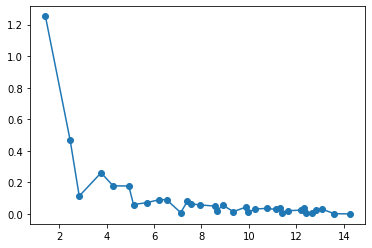

In [36]:
import matplotlib.pyplot as plt

x = np.arange(1,35)
y=scf_energy_arr[:] - scf_energy_arr[-1]

plt.plot(distance,y,'-o')

# COHP

In [37]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_cohp_dat.cohp')

In [38]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_1N_cohp_dat.cohp')

In [39]:
def int_cohp(cohp):
    
    cohp_data = []
    for line in cohp.data[4:-1]:
        new_line = [ float(x.strip('\n')) for x in re.split(' +', line.lstrip())]
        cohp_data.append(new_line)
    cohp_data = np.array(cohp_data)
    cohp_data[:,0] = cohp_data[:,0]*27.2114
    min_energy = cohp_data[0,0]
    max_energy = cohp_data[-1,0]
    energy_step = (max_energy-min_energy)/cohp.n_energy
    bond_strength = [np.sum((cohp_data[:,0] < 0.)*cohp_data[:,i]*energy_step) for i in range(2,cohp.n_proj+1)]
    #print(np.sum((cohp_data[:,0] < 0.)*cohp_data[:,2]*cohp_data[:,0])/cohp.n_energy)
    print(bond_strength)
    return(bond_strength)
int_cohp(cohp)

[1962.4953185873721]


[1962.4953185873721]

In [188]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_1N_cohp_dat.cohp')
CN_bond_s = int_cohp(cohp)

[1962.4953185873721]


In [189]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_2N2s_cohp_dat.cohp')
CN_bond_s = int_cohp(cohp)

[1942.6300654220017]


In [190]:
cohp = Properties_output().read_cry_doss('./data/crystal/graphene_18_3N2s_cohp_dat.cohp')
CN_bond_s = int_cohp(cohp)

[1902.5769318845519]


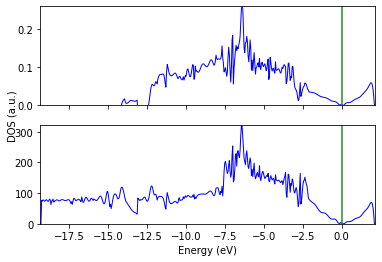

In [16]:
from plot import *
plot_cry_doss(cohp)

# N doped graphene

In [78]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell

E_graphene = Crystal_output().read_cry_output('./data/crystal/graphene_8.out').get_final_energy()
E_graphene_1N = Crystal_output().read_cry_output('./data/crystal/graphene_8_1N.out').get_final_energy()
E_graphene_2N = Crystal_output().read_cry_output('./data/crystal/graphene_8_2N.out').get_final_energy()

E_C = Crystal_output().read_cry_output('./data/crystal/c.out').get_final_energy()
E_N = Crystal_output().read_cry_output('./data/crystal/n.out').get_final_energy()

E_cc_bond = (E_graphene-(graphene_supercell.num_sites*E_C))/(graphene_supercell.num_sites*1.5)
E_cn_bond = (E_graphene_1N-((graphene_supercell.num_sites-1)*E_C + 1*E_N + 9*E_cc_bond))/3
E_nn_bond = (E_graphene_2N-((graphene_supercell.num_sites-2)*E_C + 2*E_N + 7*E_cc_bond +4*E_cn_bond))

species=[6,7]
parameters = [[E_cc_bond,E_cn_bond,E_nn_bond]]
concentration = [7,1]
chem_potential = [0.,-1.]
bqm = build_quadratic_model_discrete(structure ,species, parameters,
    concentration = None, chem_potential=chem_potential, max_neigh = 1, alpha=1,lambda_1 =5 , theta=20)
#build_qubo_matrix(bqm)

In [79]:
from dwave.system import EmbeddingComposite, DWaveSampler

sampler = EmbeddingComposite(DWaveSampler())

sampleset = sampler.sample(bqm, num_reads=1000)

In [80]:
df = sampleset.to_pandas_dataframe()
convert_df(df)

,0,1,2,3,4,5,6,7,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,1,1,0.0,-241.622396,26
5,1,1,1,1,1,1,1,0,0.0,-240.137430,18
6,1,1,1,1,1,0,1,1,0.0,-240.137430,26
7,1,1,1,1,0,1,1,1,0.0,-240.137430,19
8,1,1,1,1,1,1,0,1,0.0,-240.137430,4
27,1,1,1,1,1,0,0,1,0.0,-238.652464,7
28,1,1,1,1,0,1,0,1,0.0,-238.652464,4
29,1,1,1,1,0,0,1,1,0.0,-238.652464,16
30,1,1,1,1,1,1,0,0,0.0,-238.652464,4
31,1,1,1,1,1,0,1,0,0.0,-238.652464,18


# Hybrid method

In [119]:
from dimod import DiscreteQuadraticModel

atom_types = [6,7]

# upper matrix
bond_energy = [E_cc_bond,E_cn_bond,E_nn_bond]

A = build_adjacency_matrix(graphene_supercell)

dqm = DiscreteQuadraticModel()

for atom in range(graphene_supercell.num_sites):
    dqm.add_variable(2, label=atom)
    

for i in range(graphene_supercell.num_sites):
    for j in range(i+1,graphene_supercell.num_sites):
        for k in range(len(atom_types)):
            for m in range(k,len(atom_types)):
                if A[i,j] == 1:
                    dqm.set_quadratic(i, j, {(k, m): bond_energy[k+m]})


                
test_q = build_qubo_matrix(dqm)
dqm.to_numpy_vectors()[0]


/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_3379/3372389206.py:26: DeprecationWarning: `return_offset` will default to `True` in the future.
  dqm.to_numpy_vectors()[0]


array([ 0,  2,  4,  6,  8, 10, 12, 14], dtype=uint16)

### From QUBO

In [128]:
bqm = build_quadratic_model_discrete(structure ,species, parameters,
    concentration = concentration, chem_potential=None, max_neigh = 1, alpha=1,lambda_1 = 2, theta=0)
build_qubo_matrix(bqm) 
case_start = np.arange(0,len(atom_types)*structure.num_sites,len(atom_types))
bqm.to_numpy_vectors()[0]

array([-26.,  -2., -26.,  -2., -26.,  -2., -26.,  -2., -26.,  -2., -26.,
        -2., -26.,  -2., -26.,  -2.])

In [135]:
dqm_1 = DiscreteQuadraticModel()
dqm_1.from_numpy_vectors(case_start,bqm.to_numpy_vectors()[0],bqm.to_numpy_vectors()[1])

## Test all configurations 4x4

#### 2N

In [13]:
import sys
sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
from crystal_io import *


new_atom = 'N'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/graphene_32_confcount_2N.out')

print(cry_output.get_config_analysis())
#print(get_config_analysis_test2(cry_output))

#original_structure = cry_gui2pmg('data/classification/ml/cao_CONFCNT.gui')
original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/graphene_32_confcount_2N.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures = []
N_atoms = []
C_atoms = []
for j,substitutions in enumerate(cry_output.atom_type1):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    N_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    C_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

[[[16, 29], [29, 32], [15, 29], [29, 31], [16, 25], [25, 32], [15, 25], [12, 31]], [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]]]


In [16]:
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,structure in enumerate(structures):
    crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/2N/graphene_32_2N_%s.gui'%i)
    crystal_input.write_crystal_input('./data/crystal/2N/graphene_32_2N_%s.d12'%i)
    
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_32_2N_%s\n'%i)
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_32_2N_%s\n'%i)
    data.append('\n\n')

    
with open('./data/crystal/2N/graphene_32_2N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)


#### output

In [164]:
cry_energy_2N = []
qubo_energy_2N = []
for i in range(1,4):
    
    n_config = unique_config_2N.shape[0]
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC,E_CN,E_NN]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    q = build_interaction_matrix_test(structure, species, parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = i)
    #q = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)

    for i in range(n_config):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/2N/graphene_2N_%s.out'%i)
        crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/2N/graphene_2N_%s.gui'%i)
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        x = build_discrete_vector(atomic_numbers,num_species=2)
        qubo_energy.append(classical_energy(x,q))
    cry_energy_2N.append(cry_energy)
    qubo_energy_2N.append(qubo_energy)
cry_energy_2N = np.array(cry_energy_2N)   
qubo_energy_2N = np.array(qubo_energy_2N)

In [165]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_2N[0]



df['QUBO E 1'] = qubo_energy_2N[0]
df['QUBO E 2 '] = qubo_energy_2N[1]
df['QUBO E 3 '] = qubo_energy_2N[2]


df['Delta E 1'] = (qubo_energy_2N[0] - cry_energy_2N[0])
df['Delta E 2 '] = (qubo_energy_2N[1] - cry_energy_2N[0])
df['Delta E 3 '] = (qubo_energy_2N[2] - cry_energy_2N[0])

crystal_E_norm = cry_energy_2N[0] - np.min(cry_energy_2N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_2N[0] - np.min(qubo_energy_2N[0])
qubo2_energy_norm = qubo_energy_2N[1] - np.min(qubo_energy_2N[1])
qubo3_energy_norm = qubo_energy_2N[2] - np.min(qubo_energy_2N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)

std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]

df.loc[len(df.index)] = std

rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_2N[0],qubo_energy_2N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={5: 'STD'},inplace=True)
df.rename(index={6: 'RMSE'},inplace=True)
df = df.round(3)

df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_2N_all_CRY_QUBO.jpg')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
0,-19534.861,-19535.375,-19535.006,-19535.006,-0.515,-0.146,-0.146,0.495,0.000,0.369,0.369,-0.495,-0.126,-0.126
1,-19535.029,-19535.375,-19535.375,-19535.375,-0.347,-0.347,-0.347,0.327,0.000,0.000,0.000,-0.327,-0.327,-0.327
2,-19534.156,-19534.228,-19534.228,-19534.228,-0.072,-0.072,-0.072,1.200,1.148,1.148,1.148,-0.052,-0.052,-0.052
3,-19535.037,-19535.375,-19535.375,-19535.375,-0.339,-0.339,-0.339,0.319,0.000,0.000,0.000,-0.319,-0.319,-0.319
4,-19535.355,-19535.375,-19535.375,-19535.362,-0.020,-0.020,-0.006,0.000,0.000,0.000,0.014,0.000,0.000,0.014
STD,0.399,0.459,0.446,0.444,0.185,0.135,0.139,0.399,0.459,0.446,0.444,0.185,0.135,0.139
RMSE,0.000,0.318,0.229,0.229,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [125]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_2N[0]



df['QUBO E 1'] = qubo_energy_2N[0]
df['QUBO E 2 '] = qubo_energy_2N[1]
df['QUBO E 3 '] = qubo_energy_2N[2]


df['Delta E 1'] = (qubo_energy_2N[0] - cry_energy_2N[0])
df['Delta E 2 '] = (qubo_energy_2N[1] - cry_energy_2N[0])
df['Delta E 3 '] = (qubo_energy_2N[2] - cry_energy_2N[0])

crystal_E_norm = cry_energy_2N[0] - np.min(cry_energy_2N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_2N[0] - np.min(qubo_energy_2N[0])
qubo2_energy_norm = qubo_energy_2N[1] - np.min(qubo_energy_2N[1])
qubo3_energy_norm = qubo_energy_2N[2] - np.min(qubo_energy_2N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)

std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]

df.loc[len(df.index)] = std

rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_2N[0],qubo_energy_2N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={5: 'STD'},inplace=True)
df.rename(index={6: 'RMSE'},inplace=True)
df = df.round(3)

df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_2N_all_CRY_QUBO.jpg')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
0,-19534.861,-19535.185,-19535.017,-19535.017,-0.325,-0.157,-0.157,0.495,0.000,0.168,0.176,-0.495,-0.327,-0.319
1,-19535.029,-19535.185,-19535.185,-19535.185,-0.157,-0.157,-0.157,0.327,0.000,0.000,0.008,-0.327,-0.327,-0.319
2,-19534.156,-19534.155,-19534.155,-19534.155,0.000,0.000,0.000,1.200,1.030,1.030,1.038,-0.170,-0.170,-0.162
3,-19535.037,-19535.185,-19535.185,-19535.185,-0.149,-0.149,-0.149,0.319,0.000,0.000,0.008,-0.319,-0.319,-0.311
4,-19535.355,-19535.185,-19535.185,-19535.193,0.170,0.170,0.162,0.000,0.000,0.000,0.000,0.000,0.000,0.000
STD,0.399,0.412,0.401,0.401,0.167,0.129,0.126,0.399,0.412,0.401,0.401,0.167,0.129,0.126
RMSE,0.000,0.190,0.141,0.140,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


#### 3N

In [25]:
new_atom = 'N'

#cry_output = Crystal_output('data/classification/ml/cao_CONFCNT.out')
cry_output = Crystal_output().read_cry_output('data/crystal/graphene_32_confcount_3N.out')

cry_output.get_config_analysis()

original_structure_gui =  Crystal_gui().read_cry_gui('data/crystal/graphene_32_confcount_3N.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures = []
N_atoms = []
C_atoms = []
for j,substitutions in enumerate(cry_output.atom_type1):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    N_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    C_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

In [26]:
slurm_file = './data/crystal/slurm_file_crystal.slurm'
file = open(slurm_file, 'r')
data = file.readlines()
file.close()

for i,structure in enumerate(structures):
    crystal_input = Crystal_input().from_file('./data/crystal/graphene.d12')

    crystal_gui = cry_pmg2gui(structure,dimensionality=2)
    crystal_gui.write_crystal_gui('./data/crystal/3N/graphene_32_3N_%s.gui'%i)
    crystal_input.write_crystal_input('./data/crystal/3N/graphene_32_3N_%s.d12'%i)
    
    
    data.append('timeout 2876m /work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm graphene_32_3N_%s\n'%i)
    data.append('/work/e05/e05/bcamino/runCRYSTAL/post_proc_slurm crys graphene_32_3N_%s\n'%i)
    data.append('\n\n')

    
with open('./data/crystal/3N/graphene_32_3N_crystal.slurm', 'w') as file:
    for line in data:
        file.writelines(line)


#### output

In [166]:
cry_energy_3N = []
qubo_energy_3N = []
for j in range(1,4):    
    n_config = unique_config_3N.shape[0]
    cry_energy = []
    qubo_energy = []
    parameters = [[E_CC,E_CN,E_NN]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)]]
    parameters = [[E_CC,E_CN,E_NN],[0.,0.,(E_g2N2s-E_g2N)],[0.,0.,(E_g2N3s-E_g2N)]]
    q = build_interaction_matrix_test(structure, species, parameters, atomic_contribution=[E_C,E_N], alpha=1, max_neigh = j)
    #q = build_interaction_matrix_test(structure, species, parameters, alpha=1, max_neigh = 1)

    for i in range(n_config):
        crystal_output = Crystal_output().read_cry_output('./data/crystal/3N/graphene_3N_%s.out'%i)
        crystal_gui = Crystal_gui().read_cry_gui('./data/crystal/3N/graphene_3N_%s.gui'%i)
        cry_energy.append(crystal_output.get_final_energy())
        atomic_numbers = crystal_gui.atom_number
        #print(crystal_gui.atom_number)
        x = build_discrete_vector(atomic_numbers,num_species=2)
        qubo_energy.append(classical_energy(x,q))
        #print(np.round(classical_energy(x,q),5),np.round(crystal_output.get_final_energy(),5),classical_energy(x,q)-crystal_output.get_final_energy())
    cry_energy_3N.append(cry_energy)
    qubo_energy_3N.append(qubo_energy)

cry_energy_3N = np.array(cry_energy_3N)   
qubo_energy_3N = np.array(qubo_energy_3N)

In [167]:
df = pd.DataFrame()
df['CRYSTAL E'] = cry_energy_3N[0]



df['QUBO E 1'] = qubo_energy_3N[0]
df['QUBO E 2 '] = qubo_energy_3N[1]
df['QUBO E 3 '] = qubo_energy_3N[2]


df['Delta E 1'] = (qubo_energy_3N[0] - cry_energy_3N[0])
df['Delta E 2 '] = (qubo_energy_3N[1] - cry_energy_3N[0])
df['Delta E 3 '] = (qubo_energy_3N[2] - cry_energy_3N[0])

crystal_E_norm = cry_energy_3N[0] - np.min(cry_energy_3N[0])

df['CRY E norm'] = crystal_E_norm

qubo1_energy_norm = qubo_energy_3N[0] - np.min(qubo_energy_3N[0])
qubo2_energy_norm = qubo_energy_3N[1] - np.min(qubo_energy_3N[1])
qubo3_energy_norm = qubo_energy_3N[2] - np.min(qubo_energy_3N[2])

df['Q1 E norm'] = qubo1_energy_norm
df['Q2 E norm'] = qubo2_energy_norm
df['Q3 E norm'] = qubo3_energy_norm

df['Delta E 1 n'] = (qubo1_energy_norm - crystal_E_norm)
df['Delta E 2 n'] = (qubo2_energy_norm - crystal_E_norm)
df['Delta E 3 n'] = (qubo3_energy_norm - crystal_E_norm)

std = [np.std(df.loc[:,col].to_numpy()) for col in df.columns]

df.loc[len(df.index)] = std

rmse = []
for i in range(0,3):
    rmse.append(np.round(np.sqrt(mean_squared_error(cry_energy_3N[0],qubo_energy_3N[i])),5))
rmse = np.array(rmse)
rmse_pad = np.pad(rmse,(1,len(df.columns)-4))

df.loc[len(df.index)] = rmse_pad
df.rename(index={14: 'STD'},inplace=True)
df.rename(index={15: 'RMSE'},inplace=True)
df = df.round(3)

#dfi.export(df,'./data/images/discrete/df_3N_all_CRY_QUBO.jpg')
df

,CRYSTAL E,QUBO E 1,QUBO E 2,QUBO E 3,Delta E 1,Delta E 2,Delta E 3,CRY E norm,Q1 E norm,Q2 E norm,Q3 E norm,Delta E 1 n,Delta E 2 n,Delta E 3 n
0,-19985.808,-19986.835,-19985.728,-19985.728,-1.027,0.080,0.080,0.823,0.000,1.107,1.107,-0.823,0.284,0.284
1,-19985.961,-19986.835,-19986.097,-19986.097,-0.875,-0.136,-0.136,0.670,0.000,0.738,0.738,-0.670,0.068,0.068
2,-19985.747,-19986.835,-19985.728,-19985.728,-1.088,0.019,0.019,0.883,0.000,1.107,1.107,-0.883,0.224,0.224
3,-19985.935,-19986.835,-19985.728,-19985.728,-0.900,0.207,0.207,0.695,0.000,1.107,1.107,-0.695,0.412,0.412
4,-19985.198,-19985.687,-19985.318,-19985.318,-0.489,-0.120,-0.120,1.432,1.148,1.517,1.517,-0.284,0.085,0.085
5,-19984.385,-19984.539,-19984.170,-19984.170,-0.154,0.215,0.215,2.245,2.296,2.665,2.665,0.050,0.419,0.419
6,-19986.039,-19986.835,-19986.466,-19986.466,-0.796,-0.427,-0.427,0.592,0.000,0.369,0.369,-0.592,-0.223,-0.223
7,-19986.367,-19986.835,-19986.466,-19986.452,-0.468,-0.099,-0.085,0.263,0.000,0.369,0.383,-0.263,0.106,0.120
8,-19985.550,-19985.687,-19985.318,-19985.304,-0.137,0.232,0.245,1.081,1.148,1.517,1.531,0.067,0.436,0.450
9,-19986.631,-19986.835,-19986.466,-19986.439,-0.205,0.164,0.192,0.000,0.000,0.369,0.397,0.000,0.369,0.397
